# GANs for particles using TensorFlow

## Get the data

The training sample is shared [here](https://cernbox.cern.ch/index.php/s/RkZoMRBofrhqzZm).

These are simulated detector responses for 6 particle types (below are per-file links to the same files as above):



*   electrons https://cernbox.cern.ch/index.php/s/q5ZwDYfvOXJmnBR
*   kaons https://cernbox.cern.ch/index.php/s/nfBRDGCagdgor3q
*   muons https://cernbox.cern.ch/index.php/s/jfw0Nhyw8gYNBhk
*   pions https://cernbox.cern.ch/index.php/s/dyZJGMZuVRW0Kgg
*   protons https://cernbox.cern.ch/index.php/s/SQ6G6dmLOLTvMuz
*   ghosts https://cernbox.cern.ch/index.php/s/9Ui4xKerEDdw7Fv (these are 'fake' tracks - i.e. random tracker hits that look like a track from a real particle)



In [0]:
!pip install tensorflow-gpu

     |████████████████████████████████| 345.2MB 72kB/s 


In [0]:
import tensorflow as tf
print(tf.__version__)

1.13.1


In [0]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import files

In [0]:
# Code to read csv file into Colaboratory:

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
kaons_link = 'https://drive.google.com/open?id=1J2e0_tD4uhAKCggLB8tyyID2_5ByGYw2'
fluff, kaons_id = kaons_link.split('=')


downloaded = drive.CreateFile({'id':kaons_id}) 
downloaded.GetContentFile('kaons.csv')  
df_kaon = pd.read_csv('kaons.csv')

# Dataset is now stored in a Pandas Dataframe

In [0]:
muons_link = 'https://drive.google.com/open?id=1BRf7uXLlXQAkBayM77EgoSpqcYmIxyRV'
fluff, muons_id = muons_link.split('=')


downloaded = drive.CreateFile({'id':muons_id}) 
downloaded.GetContentFile('muons.csv')  
df_muon = pd.read_csv('muons.csv')

# Dataset is now stored in a Pandas Dataframe

In [0]:
pions_link = 'https://drive.google.com/open?id=1h9whv0LZzFXVo6yjDqA5SrLr6acU-qPj'
fluff, pions_id = pions_link.split('=')


downloaded = drive.CreateFile({'id':pions_id}) 
downloaded.GetContentFile('pions.csv')  
df_pion = pd.read_csv('pions.csv')

# Dataset is now stored in a Pandas Dataframe

In [0]:
protons_link = 'https://drive.google.com/open?id=13LKYvANBlYjwWoZxd86QYGljvyfu0AmM'
fluff, protons_id = protons_link.split('=')


downloaded = drive.CreateFile({'id':protons_id}) 
downloaded.GetContentFile('protons.csv')  
df_proton = pd.read_csv('protons.csv')

# Dataset is now stored in a Pandas Dataframe

Input variables are:
*   `TrackP` – full momentum of the particle
*   `TrackPt` – length of the momentum projection to the XY plane
*   `TrackEta` – track [pseudorapidity](https://en.wikipedia.org/wiki/Pseudorapidity)
*   `NumLongTracks` – number of reconstructed tracks in current event

Please note that among P, Pt and ETA there are only **two** independant variables. 


The variables to predict are:

*   `RichDLLbt`
*   `RichDLLk`
*   `RichDLLmu`
*   `RichDLLp`
*   `RichDLLe`


There's also one additional variable:

*   `MCParticleType` – particle [PDG code](http://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf)




In [0]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [0]:
df_kaon.describe()

,TrackPt,TrackP,NumLongTracks,MCParticleType,RichDLLbt,RichDLLk,RichDLLmu,RichDLLp,RichDLLe,TrackEta
count,999993.000,999993.000,999993.000,999993.000,999993.000,999993.000,999993.000,999993.000,999993.000,999993.000
mean,917.170,17207.830,49.570,4.437,-4.132,1.683,-17.208,-4.545,-20.286,3.480
std,870.250,21471.422,23.126,320.969,125.769,126.901,123.420,125.709,123.263,0.773
min,19.675,1143.810,1.000,-321.000,-999.000,-999.000,-999.000,-999.000,-999.000,1.542
25%,406.408,5646.150,32.000,-321.000,1.495,4.762,-3.454,1.085,-8.592,2.874
50%,675.000,10416.780,46.000,321.000,10.576,14.217,-0.926,10.074,-2.711,3.477
75%,1129.237,20396.689,64.000,321.000,20.874,25.463,0.285,20.370,-0.032,4.085
max,80601.172,1063457.375,183.000,321.000,75.218,190.337,96.350,73.100,91.978,5.946


One can see there's a peak of outliers at the left handside of the plot. Let's not bother about it so far.

## Look at the datasets

# GAN Model using TensorFlow

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from keras.models import Sequential
from keras import layers as L
from functools import partial


def get_tf_dataset(dataset, batch_size):
    N_EXAMPLES = len(dataset)
    shuffler = tf.contrib.data.shuffle_and_repeat(N_EXAMPLES)
    dataset_tf = tf.data.Dataset.from_tensor_slices(dataset)
    suffled_ds = shuffler(dataset_tf)
    
    dataset_final = suffled_ds.batch(batch_size).prefetch(1)
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset_final)
    return iterator.get_next()

def sample_noise_batch(bsize, X_DIMS):
    return np.random.normal(size=(bsize, X_DIMS)).astype('float32')



Using TensorFlow backend.


In [0]:

class Model:
    def fit(self, X, Y, n_hidden_layers=6, output_dim=128, n_epochs=4e4):
        sess = tf.InteractiveSession()
        
        GAN_TYPE = "Jensen-Shannon"

        X_DIMS, Y_DIMS = 3, 5

        generator_activation = keras.activations.elu

        with tf.name_scope("Generator"):
            generator = Sequential(name="Generator")
            generator.add(L.InputLayer([X_DIMS], name='noise'))
            for i in range(n_hidden_layers):
                generator.add(L.Dense(output_dim, activation=generator_activation))
            generator.add(L.Dense(Y_DIMS, activation=None))

        discriminator_activation = partial(keras.activations.relu, alpha=0.3)
        with tf.name_scope("Discriminator"):
            discriminator = Sequential(name="Discriminator")
            discriminator.add(L.InputLayer([Y_DIMS]))
            for i in range(n_hidden_layers):
                discriminator.add(L.Dense(output_dim, activation=discriminator_activation))          
            if GAN_TYPE == "Jensen-Shannon":
                # Jensen-Shannon expects probabilities
                discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))

        train_batch_size = int(1e3)
        real_data = get_tf_dataset(Y, train_batch_size)
        real_data = tf.dtypes.cast(real_data, tf.float32)
        noise_batch_size = tf.placeholder(tf.int32, shape=[], name="noise_batch_size")
        noise = tf.random_normal([noise_batch_size, X_DIMS], dtype=tf.float32, name="noise")
        discriminator_real = discriminator(real_data)
        generated_data = generator(noise)
        discriminator_generated = discriminator(generated_data)

        logp_real = discriminator(real_data)
        logp_gen = discriminator(generated_data)
        discriminator_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])
        
        disc_learning_rate = 1e-3
        disc_optimizer = tf.train.GradientDescentOptimizer(disc_learning_rate).minimize(
                discriminator_loss, var_list=discriminator.trainable_weights)
        
        generator_loss = -tf.reduce_mean(logp_gen[:,1])
        
        tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
        learning_rate = tf.train.exponential_decay(3e-4, tf_iter, 200, 0.98)
        gen_optimizer = tf.group(
            tf.train.AdamOptimizer(learning_rate).minimize(generator_loss, var_list=generator.trainable_weights),
            tf.assign_add(tf_iter, 1))
        
        learning_summary = tf.summary.merge([
            tf.summary.scalar("discriminator_loss", discriminator_loss),
            tf.summary.scalar("generator_loss", generator_loss),
        ])

        sess.run(tf.global_variables_initializer())

        TOTAL_ITERATIONS = int(n_epochs)
        DISCRIMINATOR_ITERATIONS = 5
        for epoch in range(TOTAL_ITERATIONS):
            for i in range(DISCRIMINATOR_ITERATIONS):
                sess.run(disc_optimizer, {noise_batch_size: train_batch_size})
            summary, _, _ = sess.run([learning_summary, gen_optimizer, tf_iter], {noise_batch_size: train_batch_size})
    
        self.generator = generator
        self.y_cols = Y.columns
        self.X_DIMS = X_DIMS
        self.sess = sess
            
    def predict(self, X):
        Y_pred = self.generator.predict(sample_noise_batch(bsize=len(X), X_DIMS=self.X_DIMS))
        Y_pred = pd.DataFrame(Y_pred)
        Y_pred.columns = self.y_cols
        return Y_pred

Using TensorFlow backend.


In [0]:
from sklearn.model_selection import KFold
from scipy.stats import ks_2samp

def score_func(sample1, sample2, n_slices=100):
    score = 0
    cols = sample1.columns
    w_normal = np.random.normal(size=(n_slices, len(cols)))
    reference = sample1.values
    
    #prediction = sample2.values
    prediction = sample2.values
    for k in range(n_slices):
        score = max(score,
                    ks_2samp(
                        np.sum(w_normal[k] * reference, axis=1),
                        np.sum(w_normal[k] * prediction, axis=1)
                    )[0]
                   )
    return score

In [0]:
def visualise_df(Y_test_list, Y_pred_list, name):
    for j in range(len(Y_test_list)):
        Y_test = Y_test_list[j]
        Y_pred = Y_pred_list[j]
        fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(8, 20))
        i = 0
        for j, col in enumerate(Y_test.columns):
            _, bins, _ = axes[i].hist(Y_test[col], bins=500 , density=True, label='test'      )
            _, _   , _ = axes[i].hist(Y_pred[col], bins=bins, density=True, label='prediction', alpha=0.7)
            axes[i].legend()
            axes[i].set_xlabel("%s: %s" % (name, col))
            axes[i].set_ylabel("prob")
            axes[i].set_xlim(left=-100)
            i += 1
        fig.show();
        plt.savefig("1d hist %s.png" % name)
        files.download("1d hist %s.png" % name)

In [0]:
def print_scores(model_scores, best_scores, name):
    print("%s:\n" % name)
    print("Model scores: mean %g, std %g" % (np.mean(model_scores), np.std(model_scores)))
    print(model_scores)
    print("Best scores:")
    print(best_scores)

In [0]:
from sklearn.model_selection import train_test_split
from time import time

x_cols = ['TrackP', 'TrackEta', 'NumLongTracks']
y_cols = ['RichDLLbt', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLe']

In [0]:
def train_df(dataframe, n_hidden_layers, output_dim, x_cols=x_cols, y_cols=y_cols, n_splits=5):
    Y_tests = []
    Y_preds = []
    model_scores = []
    best_scores = []
    
    kf = KFold(n_splits=n_splits)
    i = 0
    for train_ids, test_ids in kf.split(dataframe):
    #for i in range(n_splits):
        t = time()
        
        #train_ids, test_ids = train_test_split(np.arange(len(dataframe)), test_size=0.2, random_state=int(time()))
        X_train = dataframe[x_cols].iloc[train_ids]
        X_test = dataframe[x_cols].iloc[test_ids]
        Y_train = dataframe[y_cols].iloc[train_ids]
        Y_test = dataframe[y_cols].iloc[test_ids]
        
        model = Model()
        model.fit(X_train, Y_train, n_hidden_layers, output_dim)
        Y_pred = model.predict(X_test)
        model.sess.close()
        
        Y_tests.append(Y_test)
        Y_preds.append(Y_pred)
        model_scores.append(score_func(Y_test, Y_pred))
        best_scores.append(score_func(Y_test, Y_train))       
        
        print(i + 1, 'ended in', time() - t, 'seconds')
        i += 1
    
    return Y_tests, Y_preds, model_scores, best_scores

In [0]:
def train_full_df(dataframe):
    X = dataframe[x_cols]
    Y = dataframe[y_cols]

    model = Model()
    model.fit(X, Y)
    Y_pred = model.predict(X)
    model.sess.close()

    model_score = score_func(Y, Y_pred)
    
    return [Y], [Y_pred], model_score

### Проверка обучения всех частиц

In [0]:
import matplotlib.colors as colors


def my2d_hist(df, Y_pred, df_name, x_par_name, y_par_name):

    not_outlier = df[y_par_name] > -500

    bins = np.linspace(
            start=min(df[y_par_name][not_outlier].min(), Y_pred[y_par_name].min()), 
            stop =max(df[y_par_name][not_outlier].max(), Y_pred[y_par_name].max()), 
            num=201
        )

    fig, (ax_real, ax_fake) = plt.subplots(
                                        nrows=1,
                                        ncols=2,
                                        figsize=(15, 6)
                                    )

    _, bins_x, bins_y, img_real = \
        ax_real.hist2d(
                x=df[x_par_name],
                y=df[y_par_name],
                bins=(100, bins),
                cmap='seismic',
                norm=colors.LogNorm()
            )
    _, _, _, img_fake = \
        ax_fake.hist2d(
                x=df[x_par_name],
                y=Y_pred[y_par_name],
                bins=(bins_x, bins_y),
                cmap='seismic',
                norm=colors.LogNorm()
            )


    plt.colorbar(img_real, ax=ax_real)
    ax_real.set_xlabel(x_par_name)
    ax_real.set_ylabel(y_par_name)
    ax_real.set_title('Real %s' % df_name)
    plt.colorbar(img_fake, ax=ax_fake)
    ax_fake.set_xlabel(x_par_name)
    ax_fake.set_ylabel(y_par_name)
    ax_fake.set_title('Fake %s' % df_name)

    fig.tight_layout()
    plt.savefig("2d hist %s %s - %s.png" % (df_name, x_par_name, y_par_name))
    files.download("2d hist %s %s - %s.png" % (df_name, x_par_name, y_par_name))

#### KAONS Проверка обучения

In [0]:
train_ids, test_ids = train_test_split(np.arange(len(df_kaon)), test_size=0.2, random_state=int(time()))
X, Y = df_kaon[x_cols].iloc[train_ids], df_kaon[y_cols].iloc[train_ids]
X_test, Y_test = df_kaon[x_cols].iloc[test_ids], df_kaon[y_cols].iloc[test_ids]

X_DIMS = 3
Y_DIMS = 5
n_hidden_layers = 6
output_dim = 128
n_epochs = 4e4

In [0]:
sess.close()

In [0]:
def model_predict(generator, size, y_cols=y_cols, X_DIMS=X_DIMS):
    Y_pred = generator.predict(sample_noise_batch(bsize=size, X_DIMS=X_DIMS))
    Y_pred = pd.DataFrame(Y_pred)
    Y_pred.columns = y_cols
    return Y_pred

sess = tf.InteractiveSession()

GAN_TYPE = "Jensen-Shannon"
'''
if gan_type == "W":
    GAN_TYPE = "Wasserstein"
elif gan_type == "JS":

else:
    print("Either W or JS\n")
'''

generator_activation = keras.activations.elu
'''
    generator_activation = partial(keras.activations.relu, alpha=0)
'''

with tf.name_scope("Generator"):
    # A few Deconv layers. Feel free to add more, but that will make learning even slower
    generator = Sequential(name="Generator")
    generator.add(L.InputLayer([X_DIMS], name='noise'))
    for i in range(n_hidden_layers):
        generator.add(L.Dense(output_dim, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    generator.add(L.Dense(Y_DIMS, activation=None))

discriminator_activation = partial(keras.activations.relu, alpha=0.3)
with tf.name_scope("Discriminator"):
    discriminator = Sequential(name="Discriminator")
    discriminator.add(L.InputLayer([Y_DIMS]))
    for i in range(n_hidden_layers):
        discriminator.add(L.Dense(output_dim, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))            
    if GAN_TYPE == "Jensen-Shannon":
        # Jensen-Shannon expects probabilities
        discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))
    '''
    elif GAN_TYPE == "Wasserstein":
        # Wasserstein discriminator values are unconstrained
        discriminator.add(L.Dense(1))
    '''

train_batch_size = int(1e3)
real_data = get_tf_dataset(Y, train_batch_size)
real_data = tf.dtypes.cast(real_data, tf.float32)
noise_batch_size = tf.placeholder(tf.int32, shape=[], name="noise_batch_size")
noise = tf.random_normal([noise_batch_size, X_DIMS], dtype=tf.float32, name="noise")
discriminator_real = discriminator(real_data)
generated_data = generator(noise)
discriminator_generated = discriminator(generated_data)

logp_real = discriminator(real_data)
logp_gen = discriminator(generated_data)
discriminator_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

disc_learning_rate = 1e-3
disc_optimizer = tf.train.GradientDescentOptimizer(disc_learning_rate).minimize(
        discriminator_loss, var_list=discriminator.trainable_weights)

generator_loss = -tf.reduce_mean(logp_gen[:,1])

tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
learning_rate = tf.train.exponential_decay(4e-4, tf_iter, 200, 0.98)
gen_optimizer = tf.group(
    tf.train.AdamOptimizer(learning_rate).minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

#gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(generator_loss, var_list=generator.trainable_weights)

'''
if GAN_TYPE == "Wasserstein":
    with tf.name_scope("gradient_loss"):
        alpha = tf.random_uniform(shape=[tf.shape(generated_data)[0], 1], minval=0., maxval=1.)
        interpolates = alpha*real_data + ((1.-alpha)*generated_data)
        disc_interpolates = discriminator(interpolates)
        gradients = tf.gradients(disc_interpolates, [interpolates])[0]
        slopes = tf.norm(tf.reshape(gradients, [tf.shape(gradients)[0], -1]), axis=1)
        gradient_penalty = tf.reduce_mean(tf.square(tf.maximum(tf.abs(slopes) - 1, 0)))
    EMD_loss = tf.reduce_mean(discriminator_generated) - tf.reduce_mean(discriminator_real)
    LAMBDA = 10.
    discriminator_loss = EMD_loss + LAMBDA*gradient_penalty            

    disc_optimizer = tf.train.AdamOptimizer(disc_learning_rate, beta1=0, beta2=0.9).minimize(
           discriminator_loss, var_list=discriminator.trainable_weights)            

    generator_loss = -tf.reduce_mean(discriminator_generated)
    gen_optimizer = tf.train.AdamOptimizer(1e-4, beta1=0, beta2=0.9).minimize(
        generator_loss, var_list=generator.trainable_weights)            
'''

learning_summary = tf.summary.merge([
    tf.summary.scalar("discriminator_loss", discriminator_loss),
    tf.summary.scalar("generator_loss", generator_loss),
])

sess.run(tf.global_variables_initializer())

TOTAL_ITERATIONS = int(n_epochs)
DISCRIMINATOR_ITERATIONS = 5
t = time()
for epoch in range(TOTAL_ITERATIONS):
    for i in range(DISCRIMINATOR_ITERATIONS):
        sess.run(disc_optimizer, {noise_batch_size: train_batch_size})
    summary, _, _ = sess.run([learning_summary, gen_optimizer, tf_iter], {noise_batch_size: train_batch_size})
    
    if epoch % 1000 == 0:
        print("epoch = %d, time %g" % (epoch, time() - t))
        t = time()
        Y_pred = model_predict(generator, len(X) // 10)
        print("predictions generated, time %g" % (time() - t))
        t = time()
        random_indices = np.random.choice(len(Y), size=len(Y) // 10)
        print("score = %g, time %g \n" % (score_func(Y[y_cols].iloc[random_indices], Y_pred), time() - t))
        t = time()
    #summary, _ = sess.run([learning_summary, gen_optimizer], {noise_batch_size: train_batch_size})





epoch = 0, time 1.09812
predictions generated, time 3.19142
score = 0.927449, time 2.24156 

epoch = 1000, time 20.4003
predictions generated, time 1.84793
score = 0.247903, time 2.61392 

epoch = 2000, time 20.7642
predictions generated, time 2.12095
score = 0.143452, time 2.39477 

epoch = 3000, time 21.4419
predictions generated, time 1.98983
score = 0.159752, time 2.39994 

epoch = 4000, time 20.2274
predictions generated, time 2.3759
score = 0.169627, time 2.81503 

epoch = 5000, time 20.8999
predictions generated, time 1.95232
score = 0.0649883, time 2.41285 

epoch = 6000, time 21.2187
predictions generated, time 2.15731
score = 0.0597132, time 2.40503 

epoch = 7000, time 20.1379
predictions generated, time 1.95662
score = 0.0626883, time 2.37856 

epoch = 8000, time 20.1589
predictions generated, time 1.97317
score = 0.0325754, time 2.38383 

epoch = 9000, time 20.3824
predictions generated, time 2.31089
score = 0.0520132, time 2.78912 

epoch = 10000, time 20.2014
predictions

In [0]:
Y_pred_kaon = model_predict(generator, len(X_test))

In [0]:
myscore_kaon = score_func(Y_test, Y_pred_kaon)

In [0]:
print(myscore_kaon)

0.02207011035055173


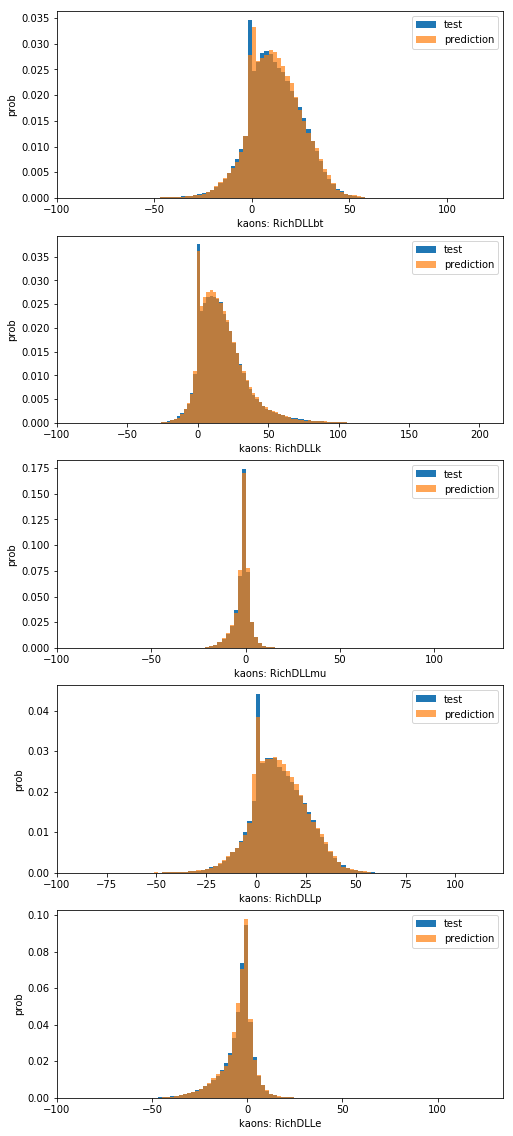

In [0]:
visualise_df([Y_test], [Y_pred_kaon], 'kaons')

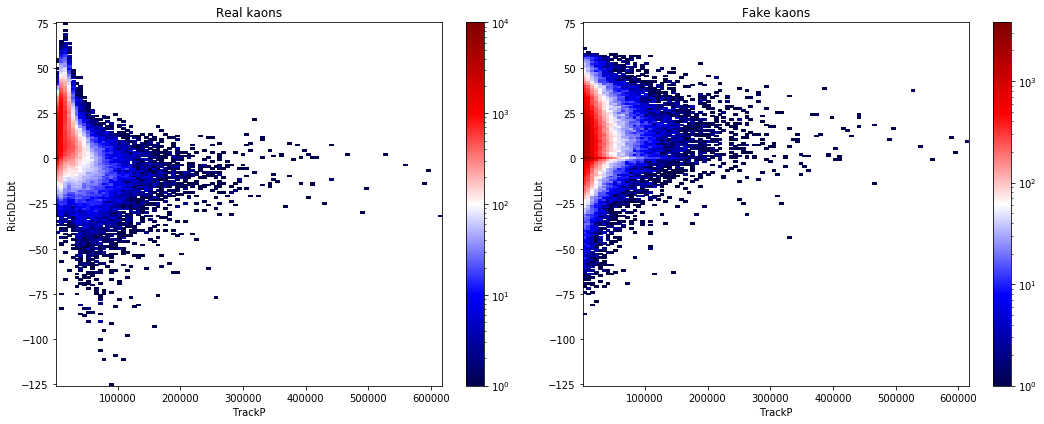

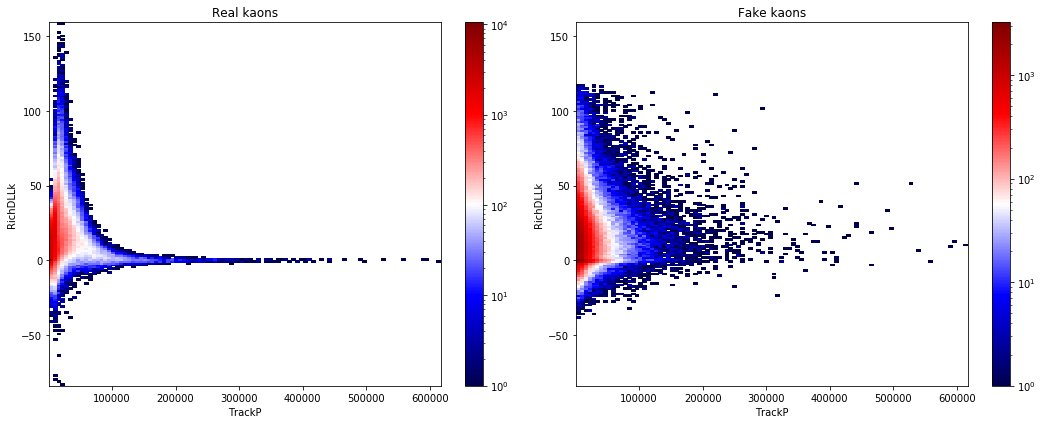

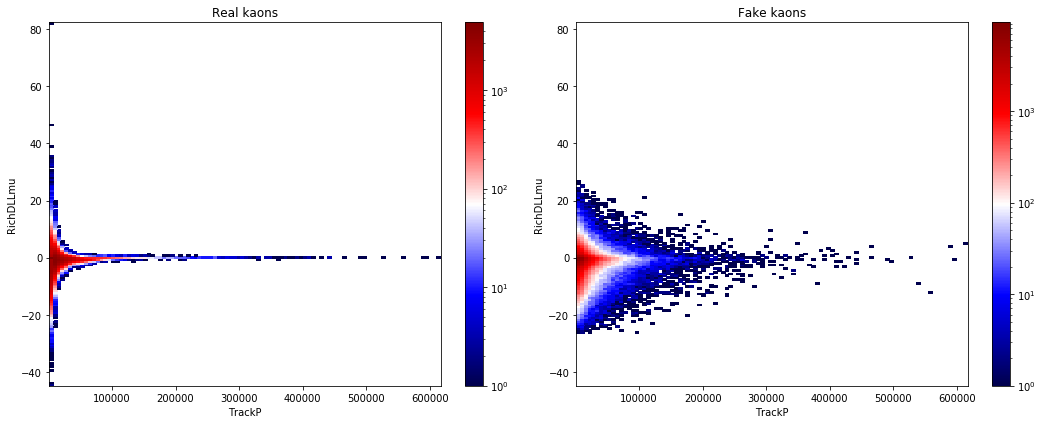

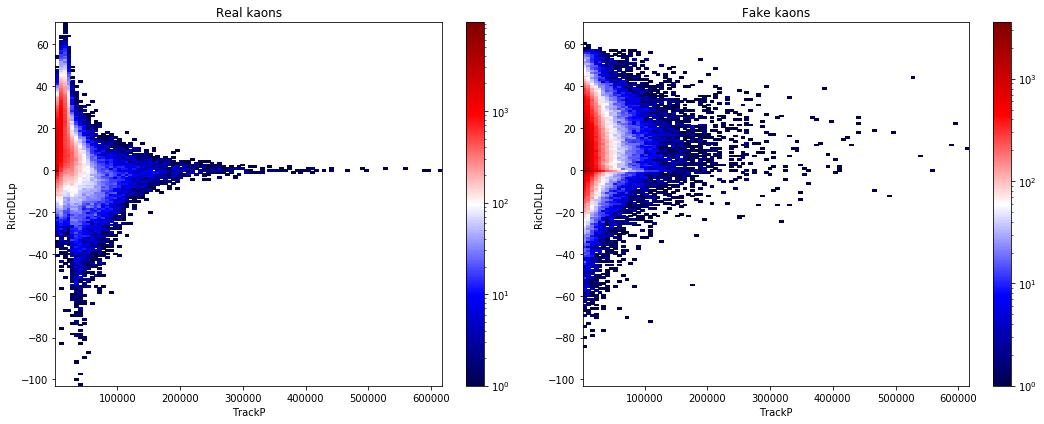

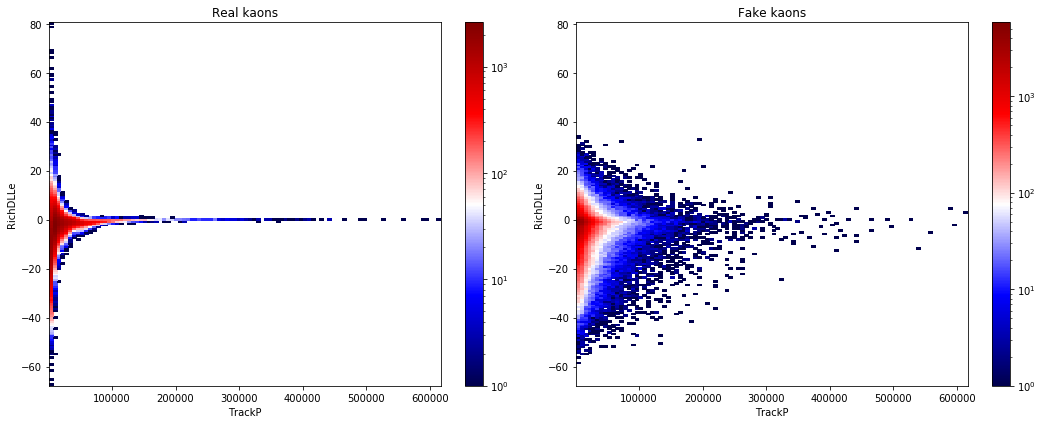

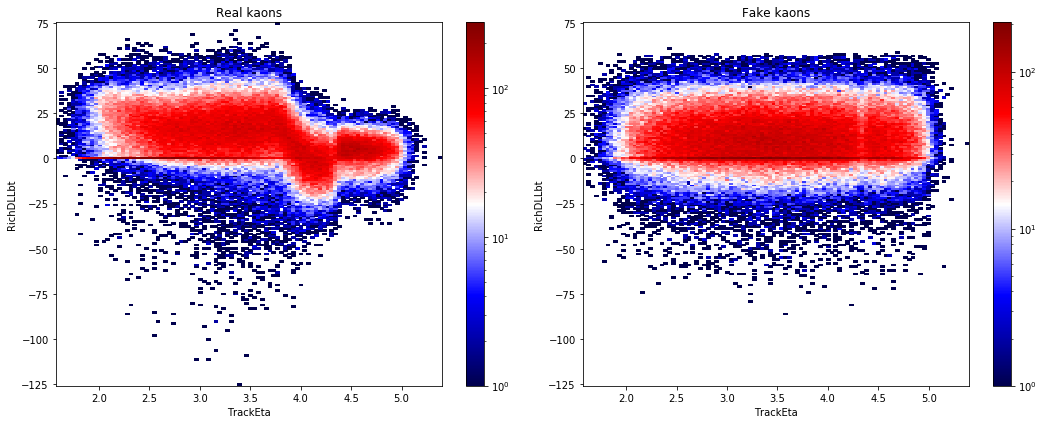

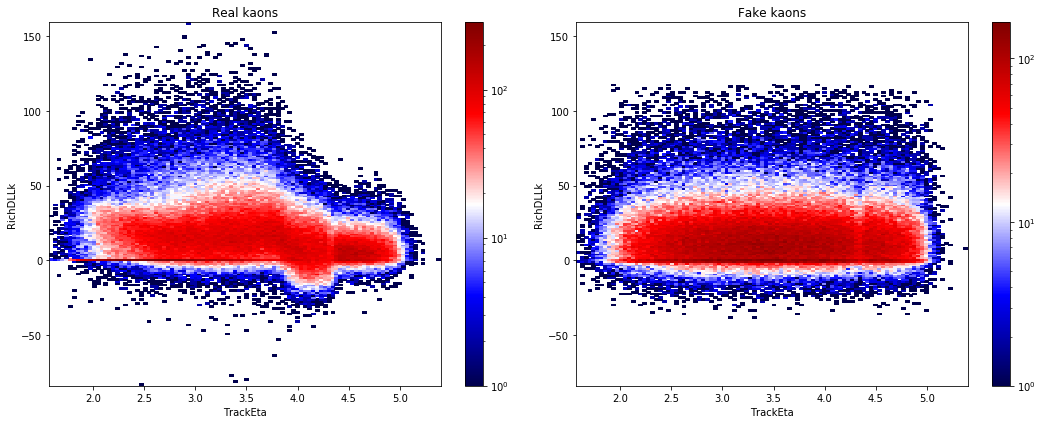

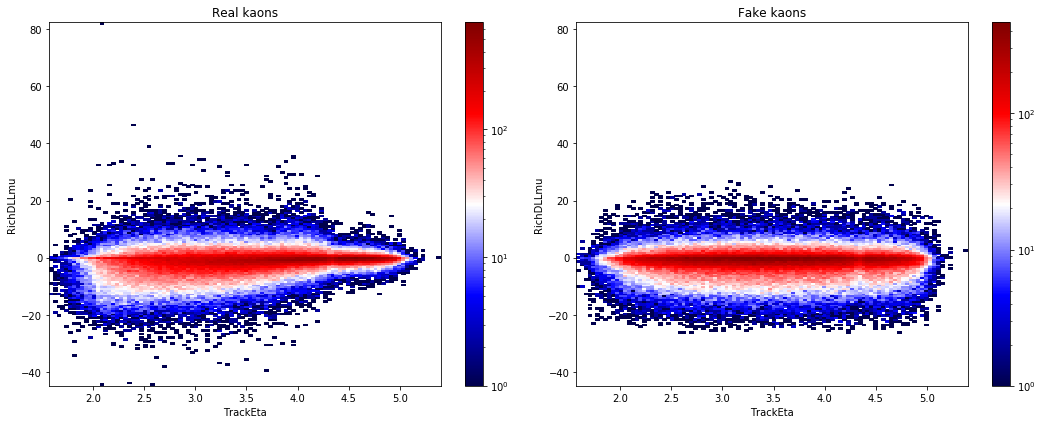

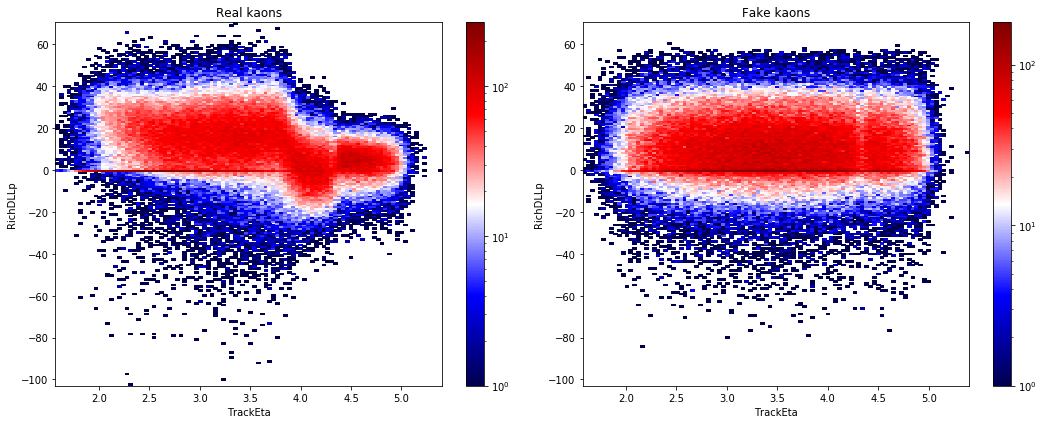

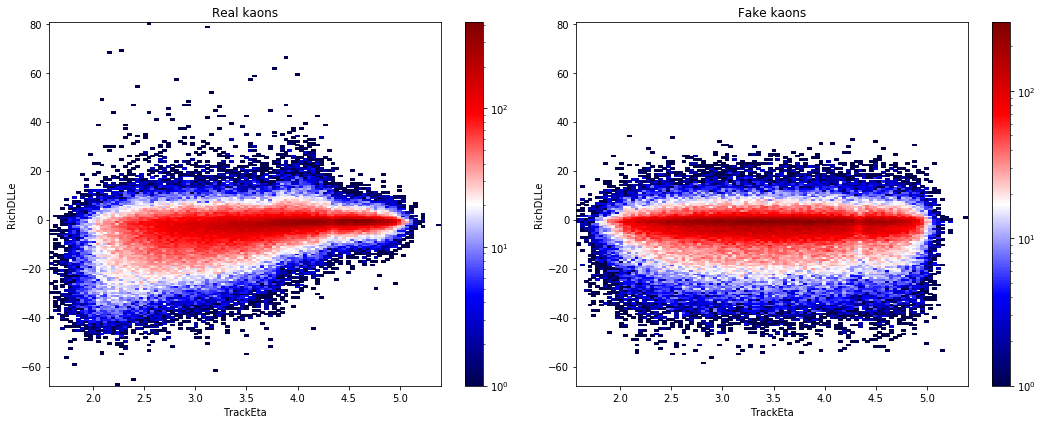

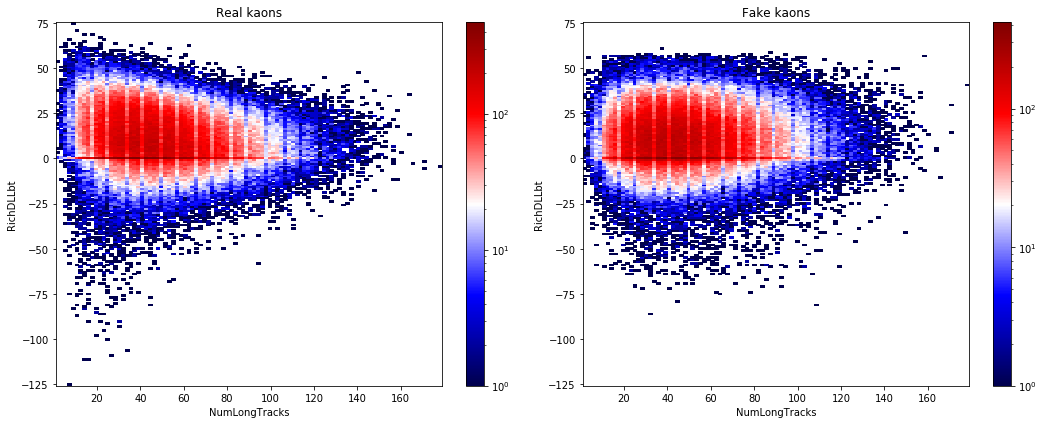

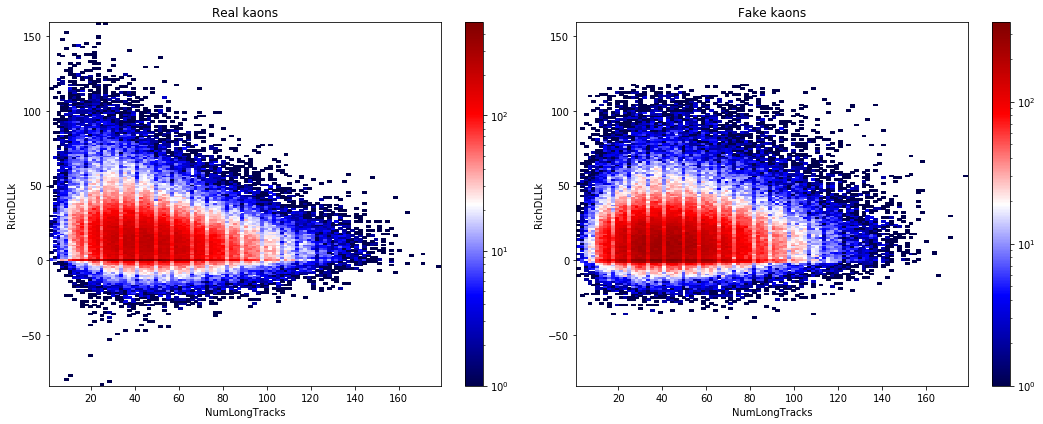

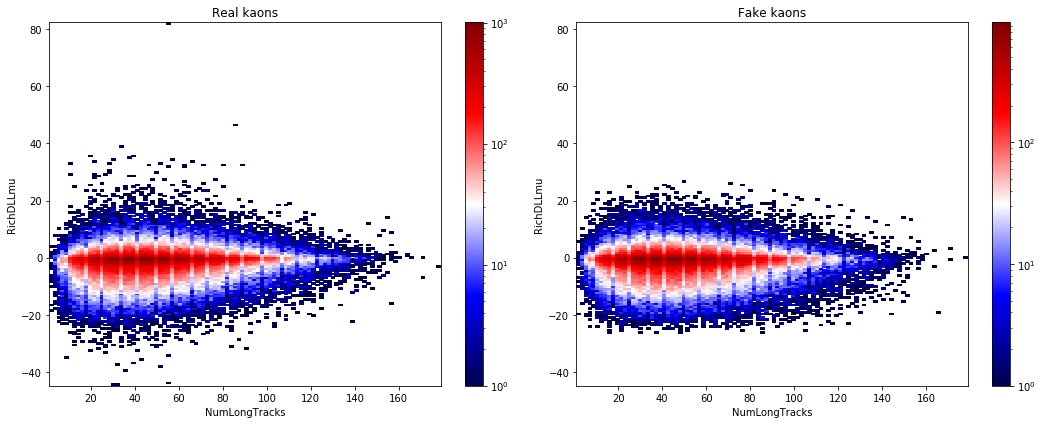

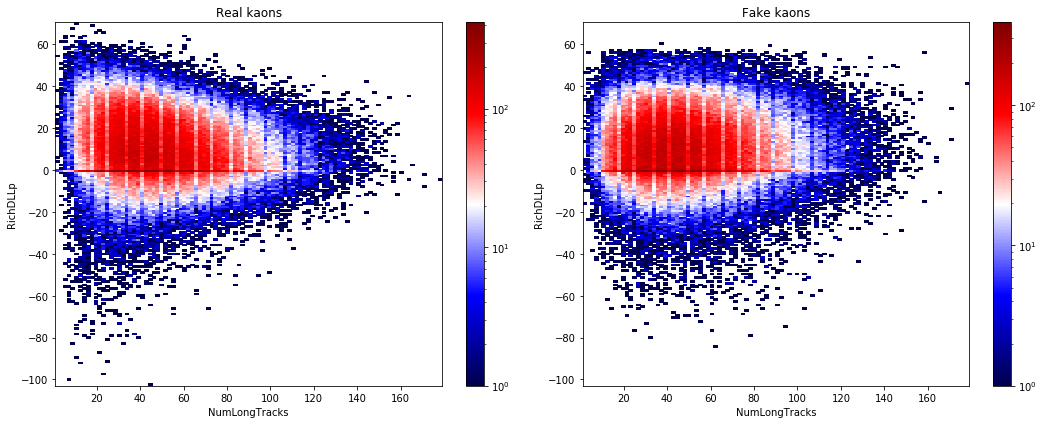

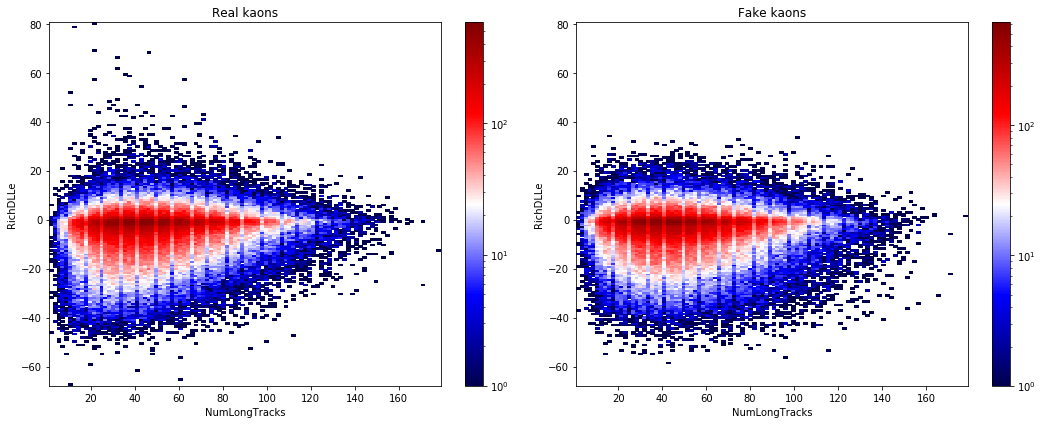

In [0]:
for x_name in x_cols:
    for y_name in y_cols:
        my2d_hist(df_kaon.iloc[test_ids], Y_pred_kaon, 'kaons', x_name, y_name)

#### MUONS Проверка обучения

In [0]:
train_ids, test_ids = train_test_split(np.arange(len(df_muon)), test_size=0.2, random_state=int(time()))
X, Y = df_muon[x_cols].iloc[train_ids], df_muon[y_cols].iloc[train_ids]
X_test, Y_test = df_muon[x_cols].iloc[test_ids], df_muon[y_cols].iloc[test_ids]

X_DIMS = 3
Y_DIMS = 5
n_hidden_layers = 6
output_dim = 128
n_epochs = 4e4

In [0]:
sess.close()

NameError: ignored

In [0]:
def model_predict(generator, size, y_cols=y_cols, X_DIMS=X_DIMS):
    Y_pred = generator.predict(sample_noise_batch(bsize=size, X_DIMS=X_DIMS))
    Y_pred = pd.DataFrame(Y_pred)
    Y_pred.columns = y_cols
    return Y_pred

sess = tf.InteractiveSession()

GAN_TYPE = "Jensen-Shannon"
'''
if gan_type == "W":
    GAN_TYPE = "Wasserstein"
elif gan_type == "JS":

else:
    print("Either W or JS\n")
'''

generator_activation = keras.activations.elu
'''
    generator_activation = partial(keras.activations.relu, alpha=0)
'''

with tf.name_scope("Generator"):
    # A few Deconv layers. Feel free to add more, but that will make learning even slower
    generator = Sequential(name="Generator")
    generator.add(L.InputLayer([X_DIMS], name='noise'))
    for i in range(n_hidden_layers):
        generator.add(L.Dense(output_dim, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    generator.add(L.Dense(Y_DIMS, activation=None))

discriminator_activation = partial(keras.activations.relu, alpha=0.3)
with tf.name_scope("Discriminator"):
    discriminator = Sequential(name="Discriminator")
    discriminator.add(L.InputLayer([Y_DIMS]))
    for i in range(n_hidden_layers):
        discriminator.add(L.Dense(output_dim, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))            
    if GAN_TYPE == "Jensen-Shannon":
        # Jensen-Shannon expects probabilities
        discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))
    '''
    elif GAN_TYPE == "Wasserstein":
        # Wasserstein discriminator values are unconstrained
        discriminator.add(L.Dense(1))
    '''

train_batch_size = int(1e3)
real_data = get_tf_dataset(Y, train_batch_size)
real_data = tf.dtypes.cast(real_data, tf.float32)
noise_batch_size = tf.placeholder(tf.int32, shape=[], name="noise_batch_size")
noise = tf.random_normal([noise_batch_size, X_DIMS], dtype=tf.float32, name="noise")
discriminator_real = discriminator(real_data)
generated_data = generator(noise)
discriminator_generated = discriminator(generated_data)

logp_real = discriminator(real_data)
logp_gen = discriminator(generated_data)
discriminator_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

disc_learning_rate = 1e-3
disc_optimizer = tf.train.GradientDescentOptimizer(disc_learning_rate).minimize(
        discriminator_loss, var_list=discriminator.trainable_weights)

generator_loss = -tf.reduce_mean(logp_gen[:,1])

tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
learning_rate = tf.train.exponential_decay(4e-4, tf_iter, 200, 0.98)
gen_optimizer = tf.group(
    tf.train.AdamOptimizer(learning_rate).minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

#gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(generator_loss, var_list=generator.trainable_weights)

'''
if GAN_TYPE == "Wasserstein":
    with tf.name_scope("gradient_loss"):
        alpha = tf.random_uniform(shape=[tf.shape(generated_data)[0], 1], minval=0., maxval=1.)
        interpolates = alpha*real_data + ((1.-alpha)*generated_data)
        disc_interpolates = discriminator(interpolates)
        gradients = tf.gradients(disc_interpolates, [interpolates])[0]
        slopes = tf.norm(tf.reshape(gradients, [tf.shape(gradients)[0], -1]), axis=1)
        gradient_penalty = tf.reduce_mean(tf.square(tf.maximum(tf.abs(slopes) - 1, 0)))
    EMD_loss = tf.reduce_mean(discriminator_generated) - tf.reduce_mean(discriminator_real)
    LAMBDA = 10.
    discriminator_loss = EMD_loss + LAMBDA*gradient_penalty            

    disc_optimizer = tf.train.AdamOptimizer(disc_learning_rate, beta1=0, beta2=0.9).minimize(
           discriminator_loss, var_list=discriminator.trainable_weights)            

    generator_loss = -tf.reduce_mean(discriminator_generated)
    gen_optimizer = tf.train.AdamOptimizer(1e-4, beta1=0, beta2=0.9).minimize(
        generator_loss, var_list=generator.trainable_weights)            
'''

learning_summary = tf.summary.merge([
    tf.summary.scalar("discriminator_loss", discriminator_loss),
    tf.summary.scalar("generator_loss", generator_loss),
])

sess.run(tf.global_variables_initializer())

TOTAL_ITERATIONS = int(n_epochs)
DISCRIMINATOR_ITERATIONS = 5
t = time()
for epoch in range(TOTAL_ITERATIONS):
    for i in range(DISCRIMINATOR_ITERATIONS):
        sess.run(disc_optimizer, {noise_batch_size: train_batch_size})
    summary, _, _ = sess.run([learning_summary, gen_optimizer, tf_iter], {noise_batch_size: train_batch_size})
    
    if epoch % 1000 == 0:
        print("epoch = %d, time %g" % (epoch, time() - t))
        t = time()
        Y_pred = model_predict(generator, len(X) // 10)
        print("predictions generated, time %g" % (time() - t))
        t = time()
        random_indices = np.random.choice(len(Y), size=len(Y) // 10)
        print("score = %g, time %g \n" % (score_func(Y[y_cols].iloc[random_indices], Y_pred), time() - t))
        t = time()
    #summary, _ = sess.run([learning_summary, gen_optimizer], {noise_batch_size: train_batch_size})





Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.data.experimental.shuffle_and_repeat(...)`.
epoch = 0, time 1.39929
predictions generated, time 1.88647
score = 0.927712, time 2.38339 

epoch = 1000, time 21.0151
predictions generated, time 1.65964
score = 0.182775, time 2.51264 

epoch = 2000, time 20.9981
predictions generated, time 1.65127
score = 0.16595, time 2.64465 

epoch = 3000, time 21.1042
predictions generated, time 1.73396
score = 0.148337, time 2.78719 

epoch = 4000, time 20.9339
predictions generated, time 1.60486
score = 0.113825, time 2.45738 

epoch = 5000, time 21.7222
predictions generated, time 1.59003
score = 0.0989, time 2.60441 

epoch = 6000, time 20.5376
predictions gene

In [0]:
Y_pred_muon = model_predict(generator, len(X_test))

In [0]:
myscore_muon = score_func(Y_test, Y_pred_muon)

In [0]:
print(myscore_muon)

0.017874910625446883


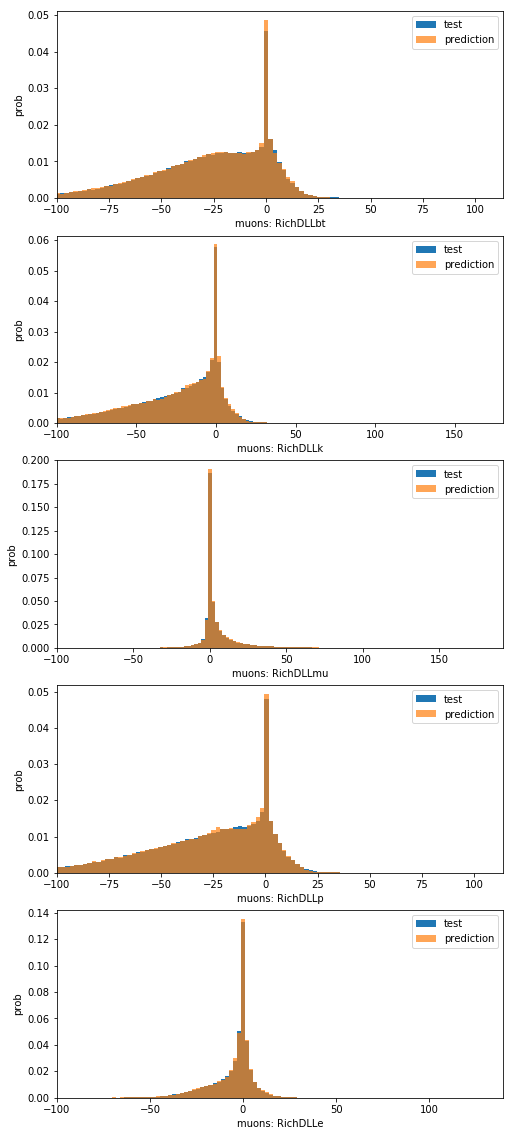

In [0]:
visualise_df([Y_test], [Y_pred_muon], 'muons')

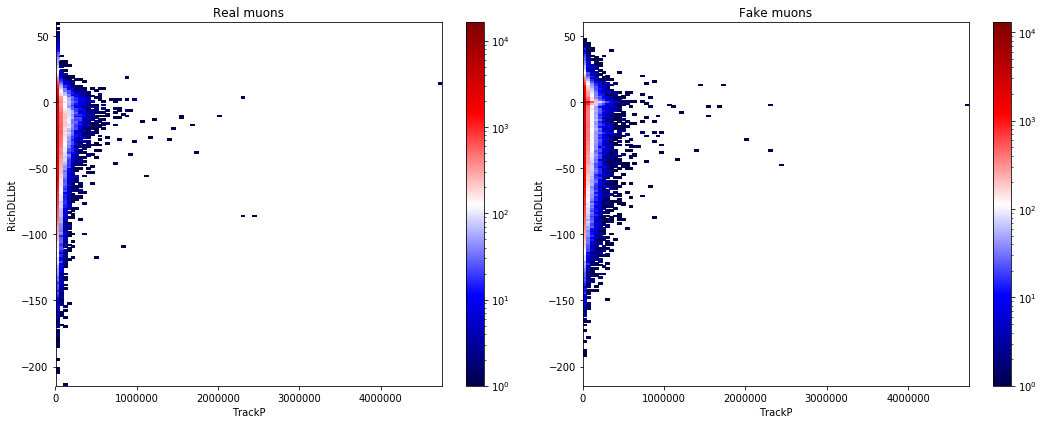

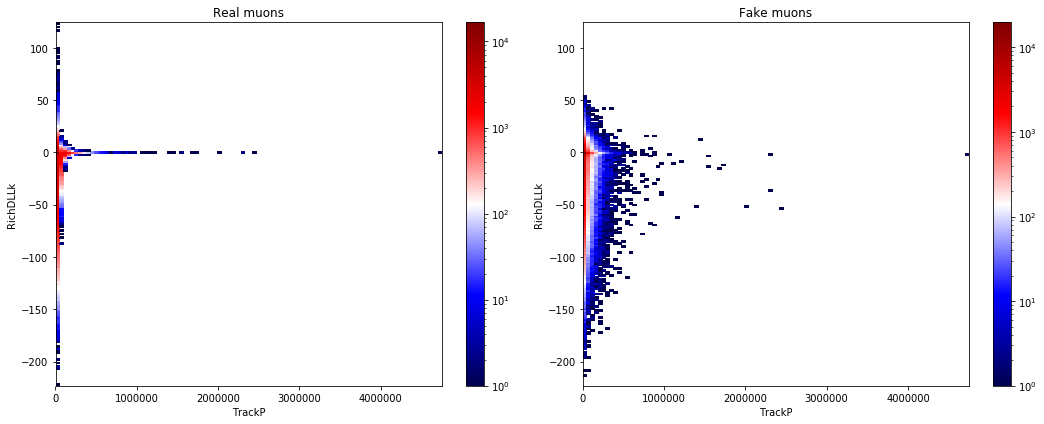

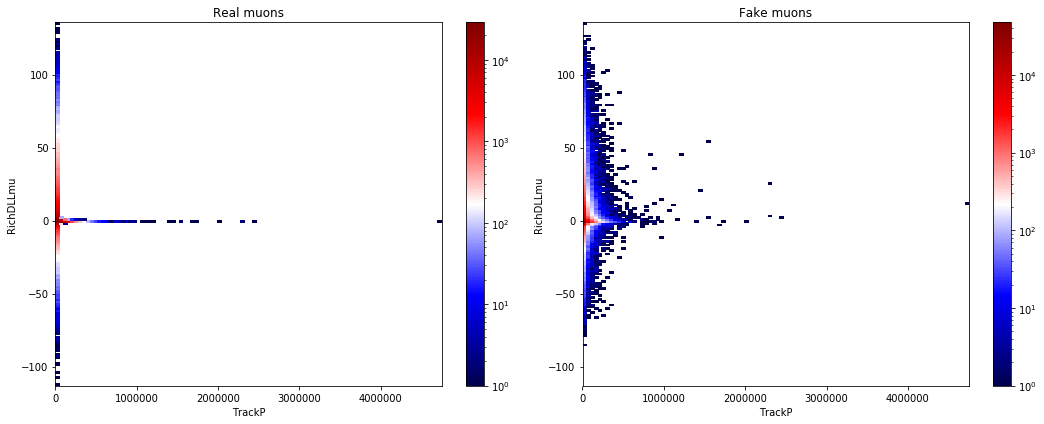

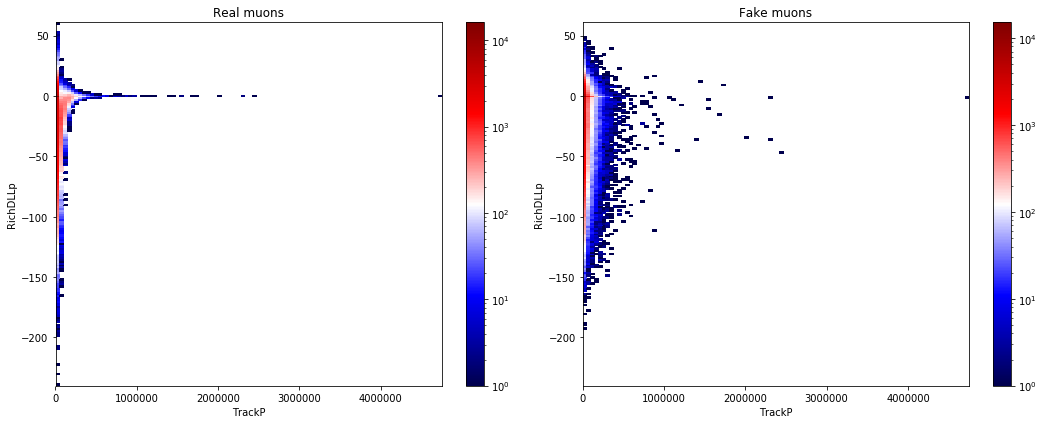

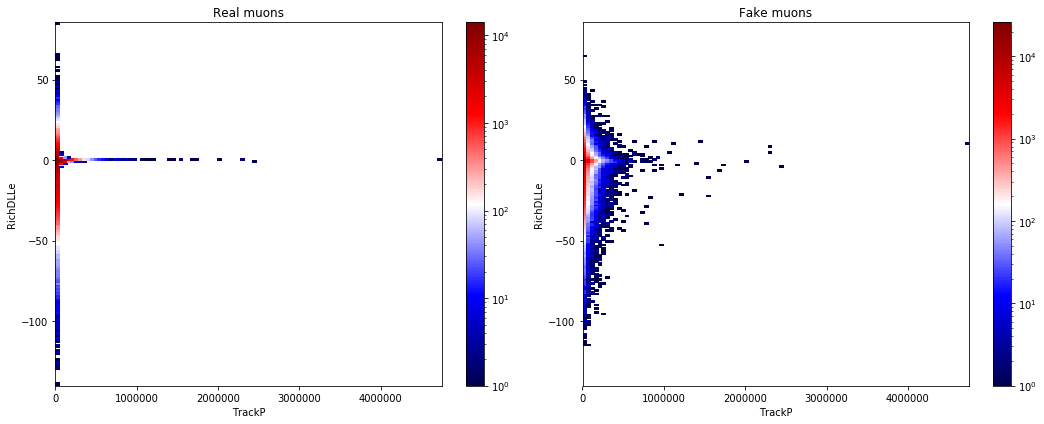

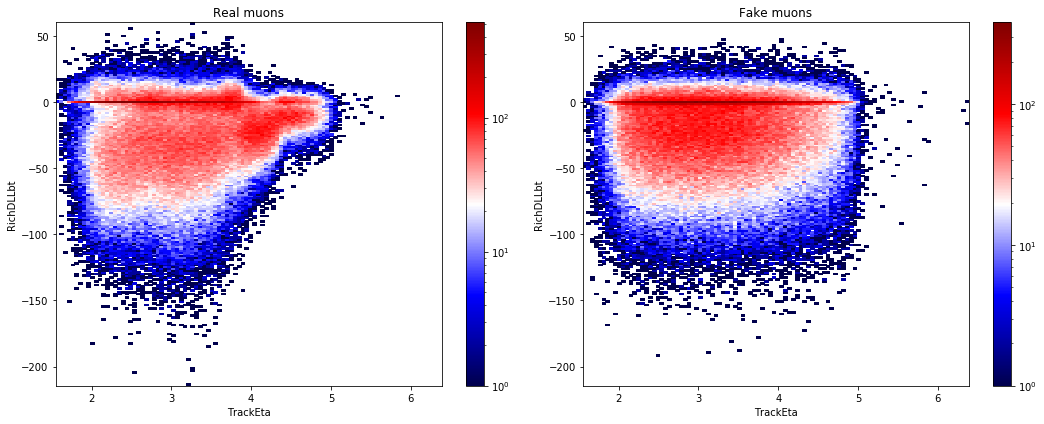

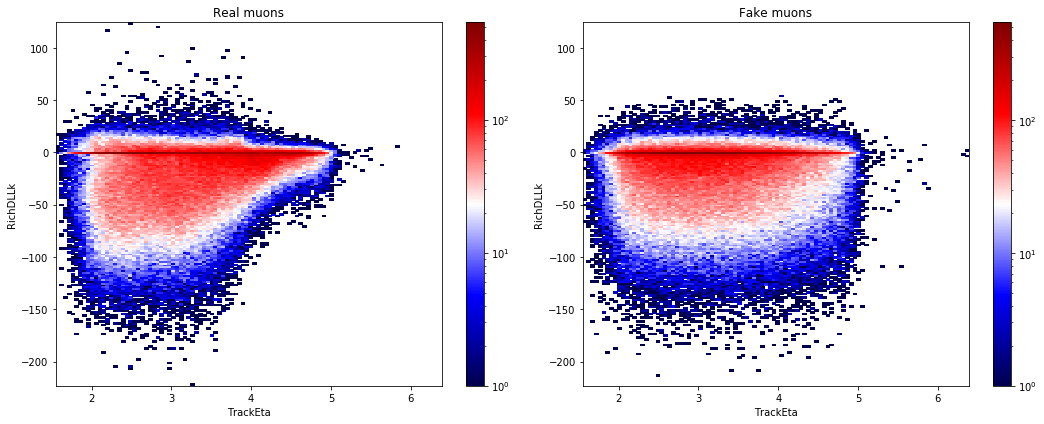

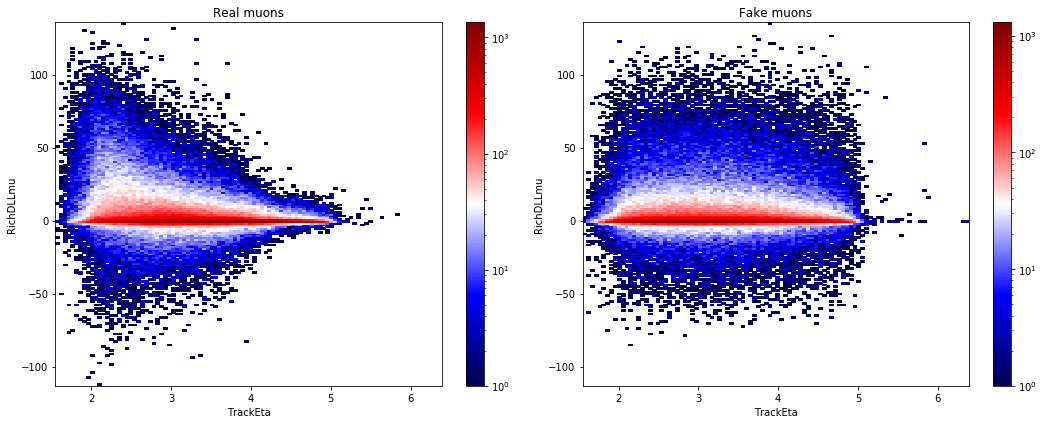

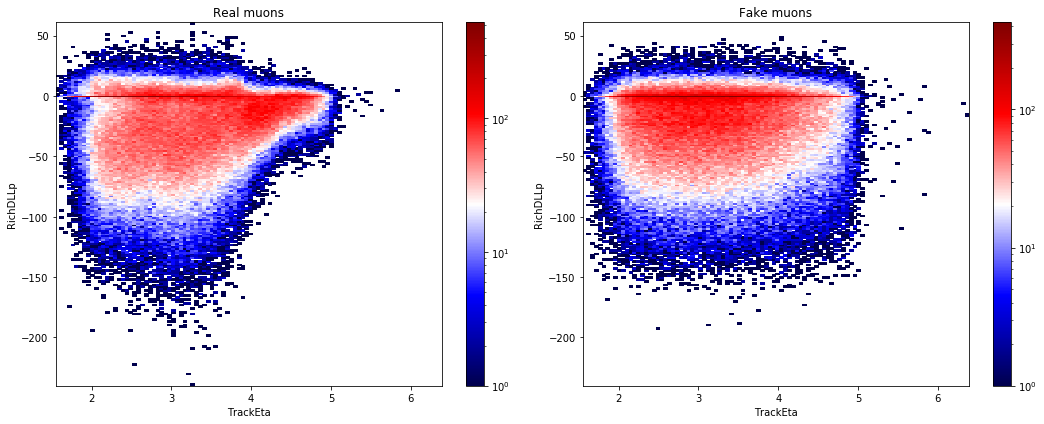

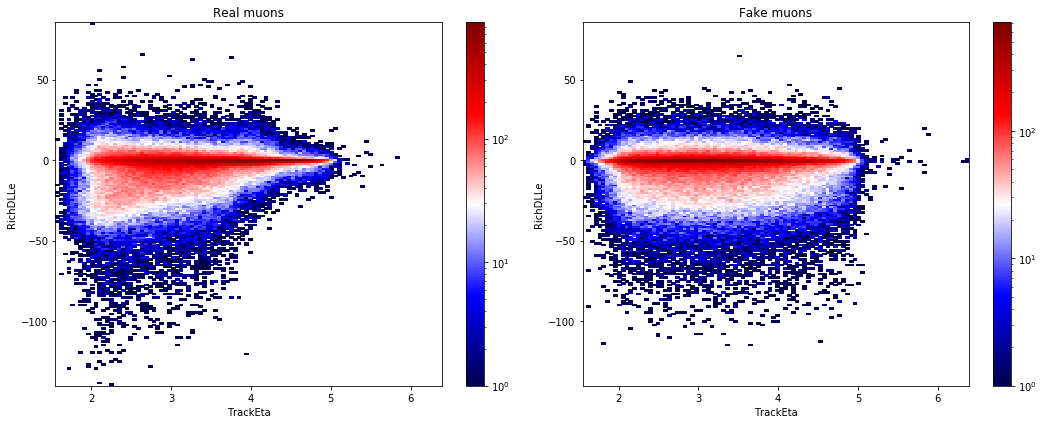

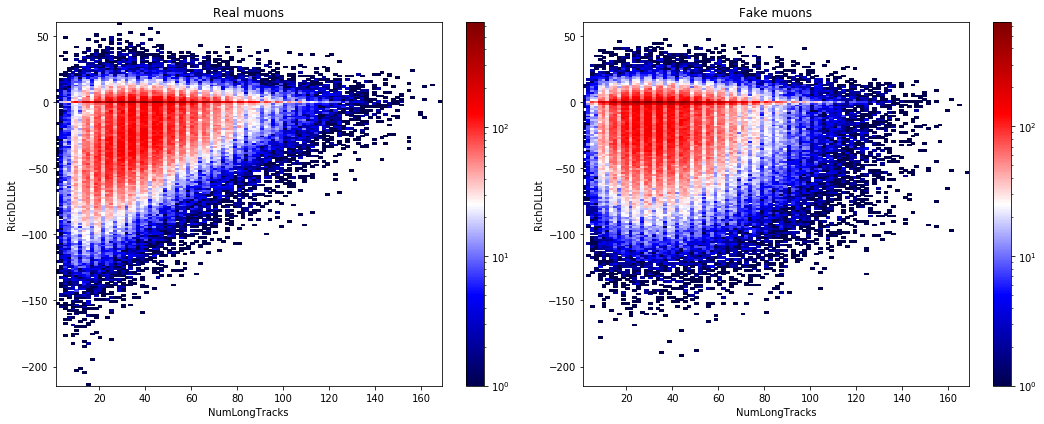

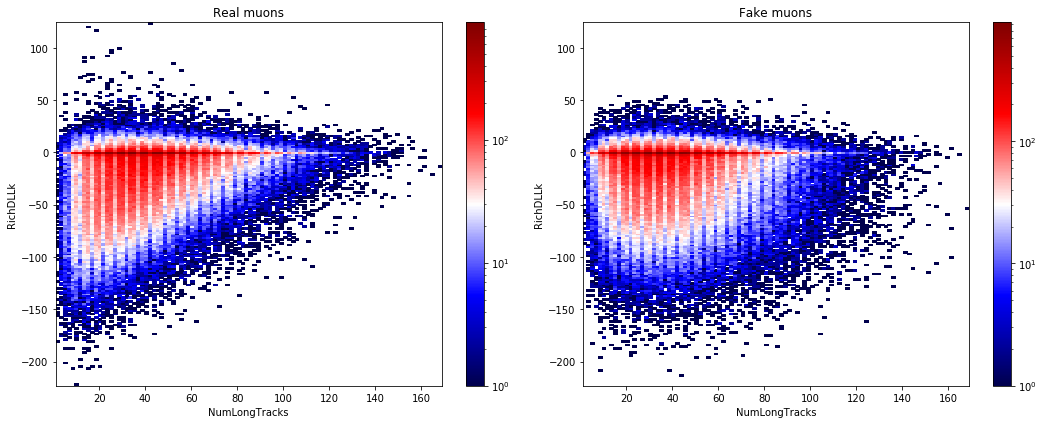

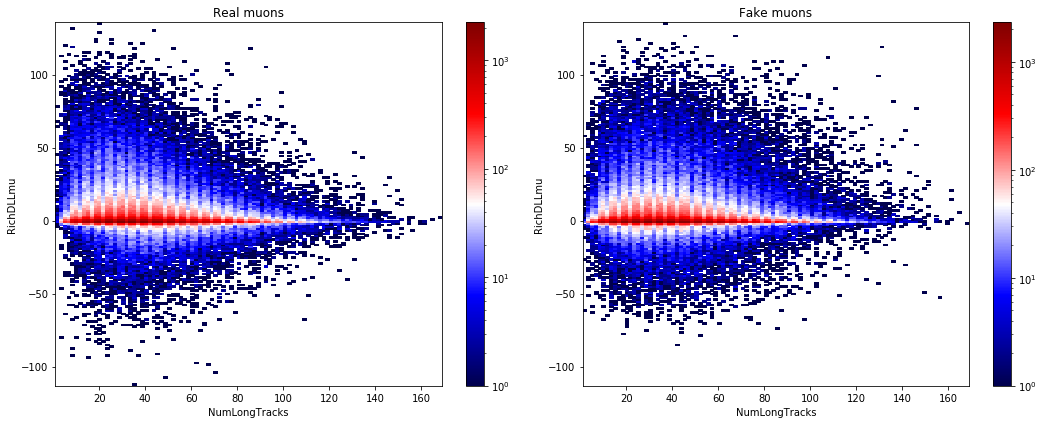

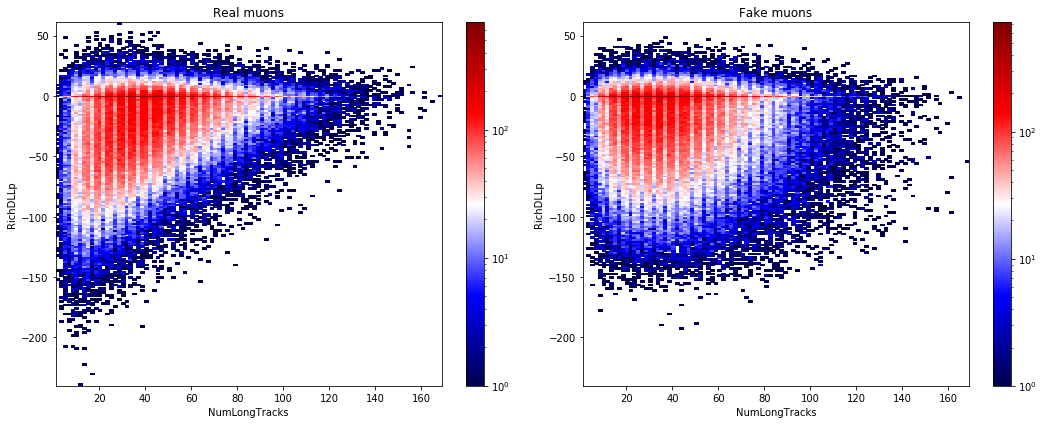

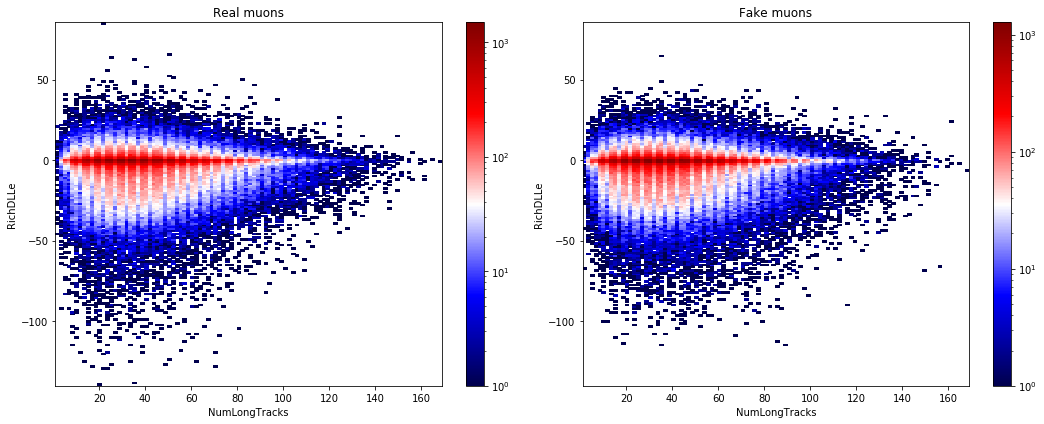

In [0]:
for x_name in x_cols:
    for y_name in y_cols:
        my2d_hist(df_muon.iloc[test_ids], Y_pred_muon, 'muons', x_name, y_name)

#### PIONS  Проверка обучения

In [0]:
train_ids, test_ids = train_test_split(np.arange(len(df_pion)), test_size=0.2, random_state=int(time()))
X, Y = df_pion[x_cols].iloc[train_ids], df_pion[y_cols].iloc[train_ids]
X_test, Y_test = df_pion[x_cols].iloc[test_ids], df_pion[y_cols].iloc[test_ids]

X_DIMS = 3
Y_DIMS = 5
n_hidden_layers = 6
output_dim = 128
n_epochs = 4e4

In [0]:
sess.close()

In [0]:
def model_predict(generator, size, y_cols=y_cols, X_DIMS=X_DIMS):
    Y_pred = generator.predict(sample_noise_batch(bsize=size, X_DIMS=X_DIMS))
    Y_pred = pd.DataFrame(Y_pred)
    Y_pred.columns = y_cols
    return Y_pred

sess = tf.InteractiveSession()

GAN_TYPE = "Jensen-Shannon"
'''
if gan_type == "W":
    GAN_TYPE = "Wasserstein"
elif gan_type == "JS":

else:
    print("Either W or JS\n")
'''

generator_activation = keras.activations.elu
'''
    generator_activation = partial(keras.activations.relu, alpha=0)
'''

with tf.name_scope("Generator"):
    # A few Deconv layers. Feel free to add more, but that will make learning even slower
    generator = Sequential(name="Generator")
    generator.add(L.InputLayer([X_DIMS], name='noise'))
    for i in range(n_hidden_layers):
        generator.add(L.Dense(output_dim, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    generator.add(L.Dense(Y_DIMS, activation=None))

discriminator_activation = partial(keras.activations.relu, alpha=0.3)
with tf.name_scope("Discriminator"):
    discriminator = Sequential(name="Discriminator")
    discriminator.add(L.InputLayer([Y_DIMS]))
    for i in range(n_hidden_layers):
        discriminator.add(L.Dense(output_dim, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))            
    if GAN_TYPE == "Jensen-Shannon":
        # Jensen-Shannon expects probabilities
        discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))
    '''
    elif GAN_TYPE == "Wasserstein":
        # Wasserstein discriminator values are unconstrained
        discriminator.add(L.Dense(1))
    '''

train_batch_size = int(1e3)
real_data = get_tf_dataset(Y, train_batch_size)
real_data = tf.dtypes.cast(real_data, tf.float32)
noise_batch_size = tf.placeholder(tf.int32, shape=[], name="noise_batch_size")
noise = tf.random_normal([noise_batch_size, X_DIMS], dtype=tf.float32, name="noise")
discriminator_real = discriminator(real_data)
generated_data = generator(noise)
discriminator_generated = discriminator(generated_data)

logp_real = discriminator(real_data)
logp_gen = discriminator(generated_data)
discriminator_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

disc_learning_rate = 1e-3
disc_optimizer = tf.train.GradientDescentOptimizer(disc_learning_rate).minimize(
        discriminator_loss, var_list=discriminator.trainable_weights)

generator_loss = -tf.reduce_mean(logp_gen[:,1])

tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
learning_rate = tf.train.exponential_decay(4e-4, tf_iter, 200, 0.98)
gen_optimizer = tf.group(
    tf.train.AdamOptimizer(learning_rate).minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

#gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(generator_loss, var_list=generator.trainable_weights)

'''
if GAN_TYPE == "Wasserstein":
    with tf.name_scope("gradient_loss"):
        alpha = tf.random_uniform(shape=[tf.shape(generated_data)[0], 1], minval=0., maxval=1.)
        interpolates = alpha*real_data + ((1.-alpha)*generated_data)
        disc_interpolates = discriminator(interpolates)
        gradients = tf.gradients(disc_interpolates, [interpolates])[0]
        slopes = tf.norm(tf.reshape(gradients, [tf.shape(gradients)[0], -1]), axis=1)
        gradient_penalty = tf.reduce_mean(tf.square(tf.maximum(tf.abs(slopes) - 1, 0)))
    EMD_loss = tf.reduce_mean(discriminator_generated) - tf.reduce_mean(discriminator_real)
    LAMBDA = 10.
    discriminator_loss = EMD_loss + LAMBDA*gradient_penalty            

    disc_optimizer = tf.train.AdamOptimizer(disc_learning_rate, beta1=0, beta2=0.9).minimize(
           discriminator_loss, var_list=discriminator.trainable_weights)            

    generator_loss = -tf.reduce_mean(discriminator_generated)
    gen_optimizer = tf.train.AdamOptimizer(1e-4, beta1=0, beta2=0.9).minimize(
        generator_loss, var_list=generator.trainable_weights)            
'''

learning_summary = tf.summary.merge([
    tf.summary.scalar("discriminator_loss", discriminator_loss),
    tf.summary.scalar("generator_loss", generator_loss),
])

sess.run(tf.global_variables_initializer())

TOTAL_ITERATIONS = int(n_epochs)
DISCRIMINATOR_ITERATIONS = 5
t = time()
for epoch in range(TOTAL_ITERATIONS):
    for i in range(DISCRIMINATOR_ITERATIONS):
        sess.run(disc_optimizer, {noise_batch_size: train_batch_size})
    summary, _, _ = sess.run([learning_summary, gen_optimizer, tf_iter], {noise_batch_size: train_batch_size})
    
    if epoch % 1000 == 0:
        print("epoch = %d, time %g" % (epoch, time() - t))
        t = time()
        Y_pred = model_predict(generator, len(X) // 10)
        print("predictions generated, time %g" % (time() - t))
        t = time()
        random_indices = np.random.choice(len(Y), size=len(Y) // 10)
        print("score = %g, time %g \n" % (score_func(Y[y_cols].iloc[random_indices], Y_pred), time() - t))
        t = time()
    #summary, _ = sess.run([learning_summary, gen_optimizer], {noise_batch_size: train_batch_size})





epoch = 0, time 0.867288
predictions generated, time 2.57
score = 0.934188, time 2.30346 

epoch = 1000, time 21.7782
predictions generated, time 1.9549
score = 0.355913, time 2.55804 

epoch = 2000, time 20.9597
predictions generated, time 1.95069
score = 0.14065, time 2.46917 

epoch = 3000, time 20.7869
predictions generated, time 1.9605
score = 0.131563, time 2.49092 

epoch = 4000, time 21.6515
predictions generated, time 1.93068
score = 0.220375, time 2.55259 

epoch = 5000, time 21.1391
predictions generated, time 1.88857
score = 0.0546125, time 2.45356 

epoch = 6000, time 21.7165
predictions generated, time 2.01698
score = 0.088625, time 2.43647 

epoch = 7000, time 21.2846
predictions generated, time 1.89734
score = 0.0694, time 2.45298 

epoch = 8000, time 20.3215
predictions generated, time 1.89881
score = 0.0898875, time 2.42558 

epoch = 9000, time 20.2509
predictions generated, time 1.90903
score = 0.0802125, time 2.40458 

epoch = 10000, time 20.82
predictions generated

In [0]:
Y_pred_pion = model_predict(generator, len(X_test))

In [0]:
myscore_pion = score_func(Y_test, Y_pred_pion)

In [0]:
print(myscore_pion)

0.03546464535354646


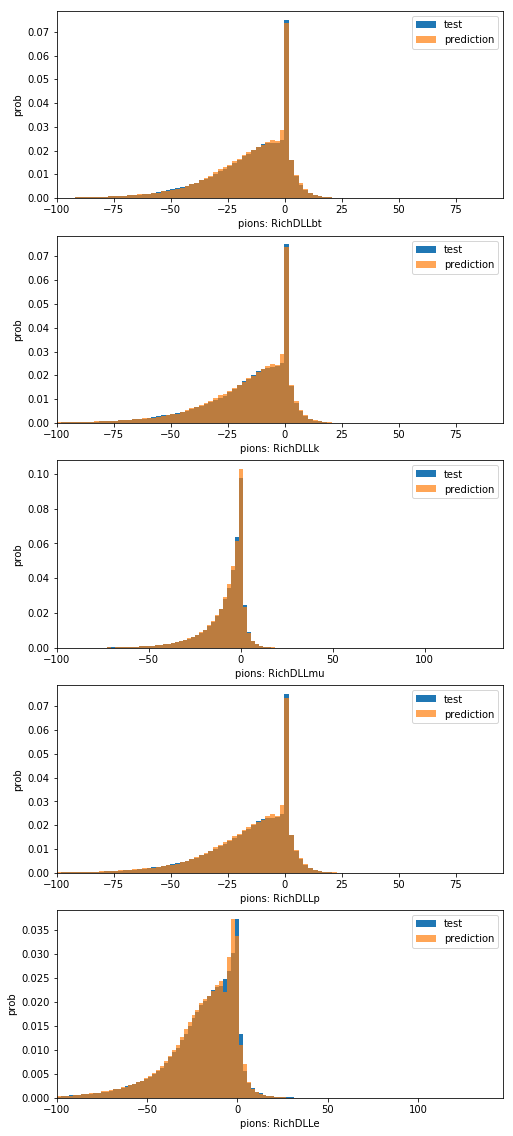

In [0]:
visualise_df([Y_test], [Y_pred_pion], 'pions')

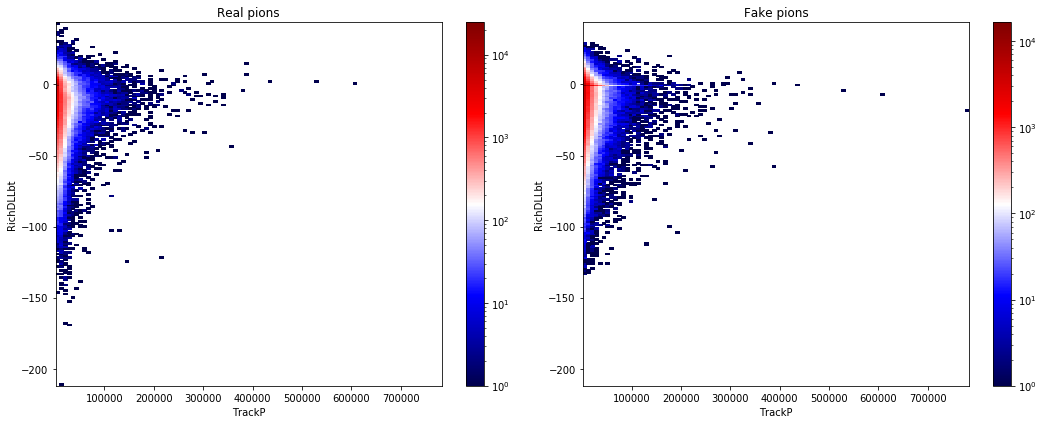

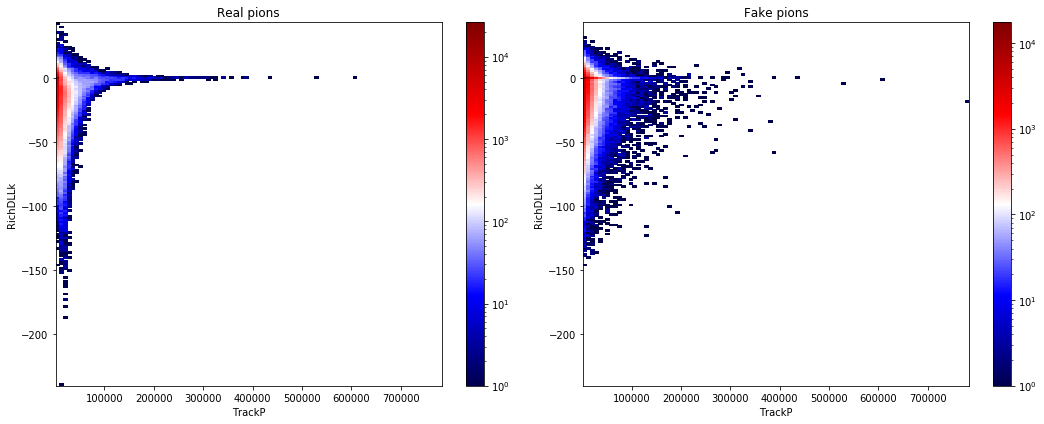

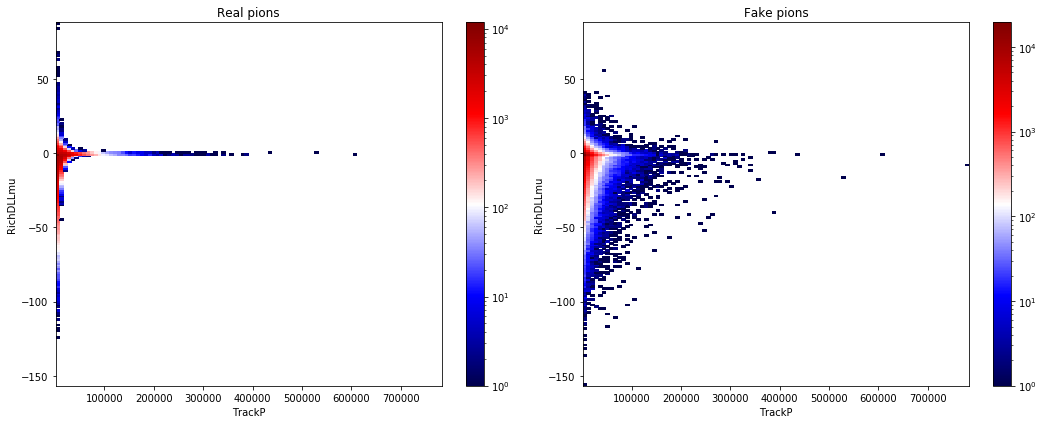

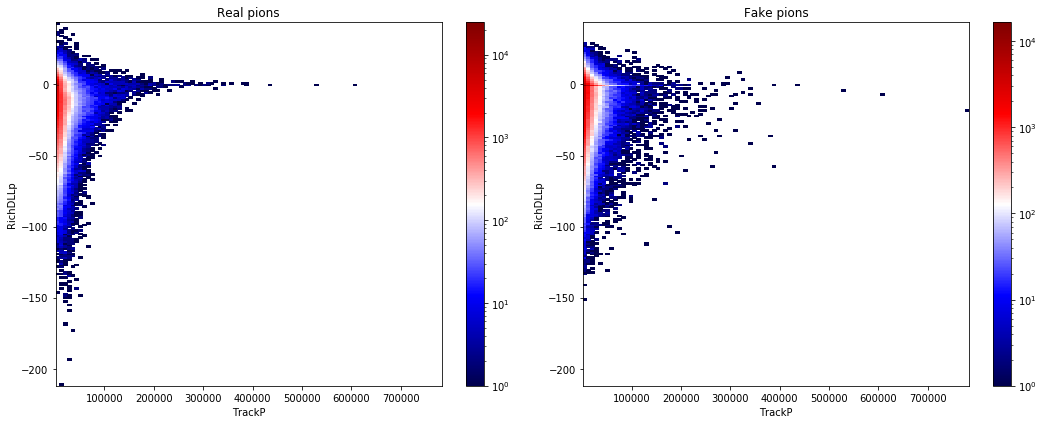

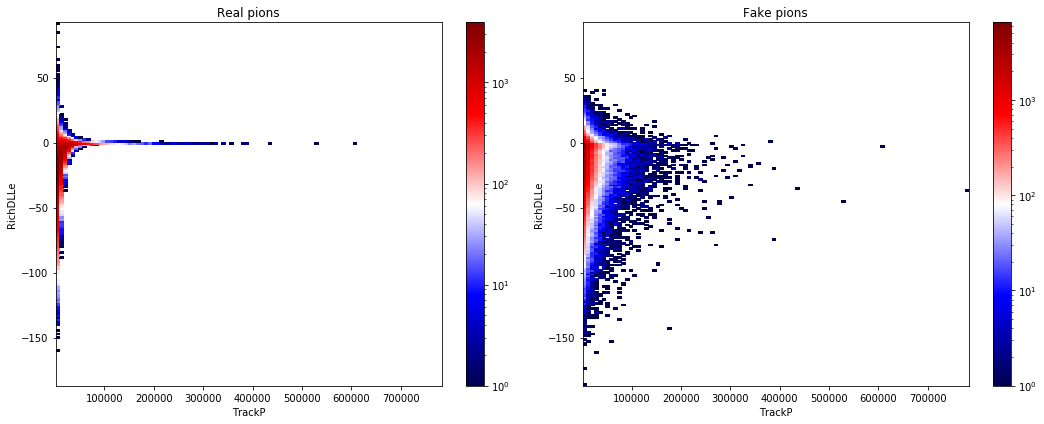

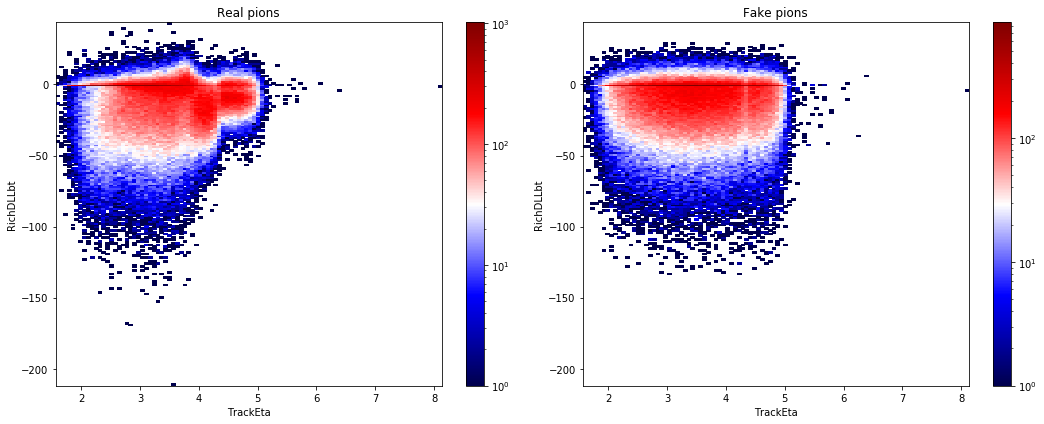

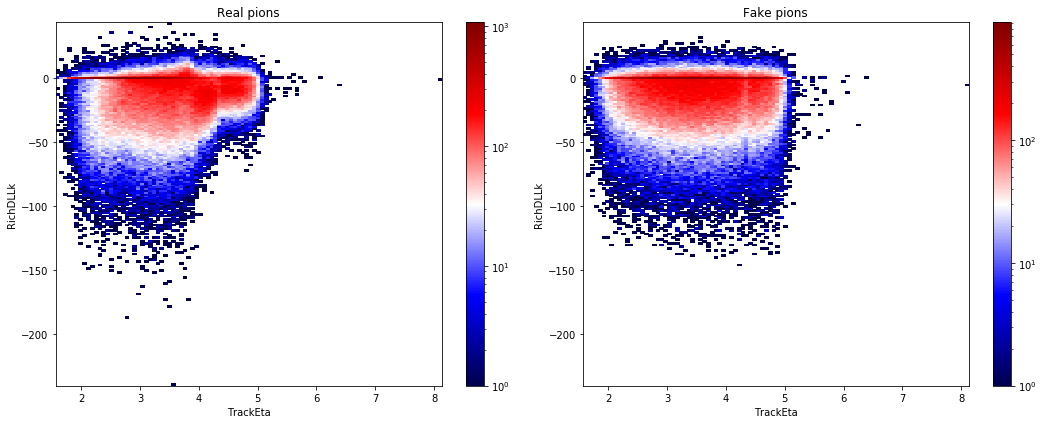

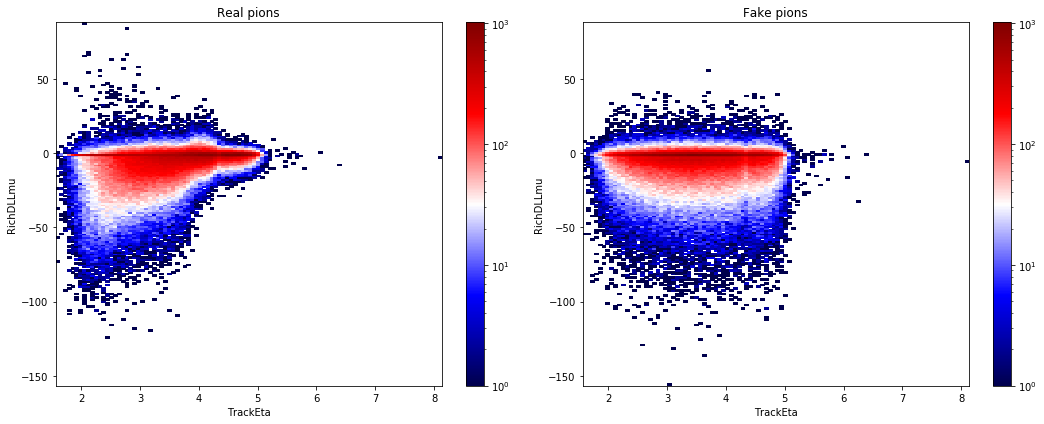

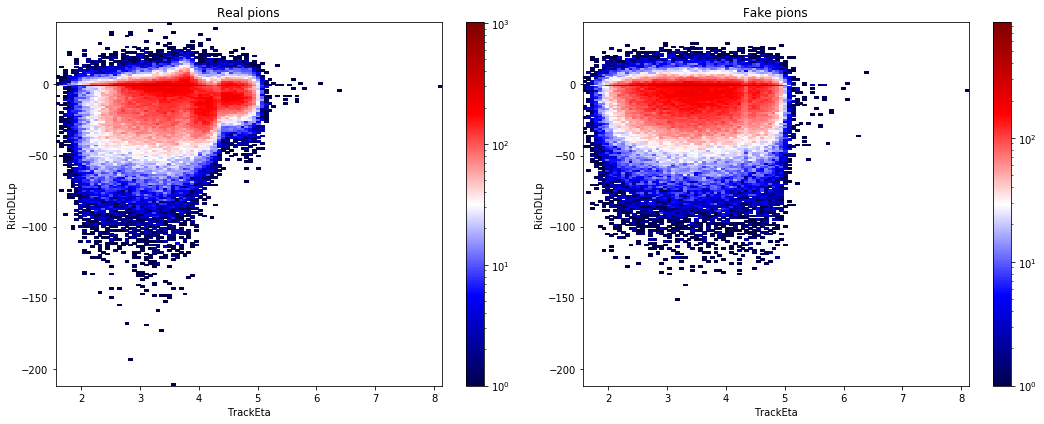

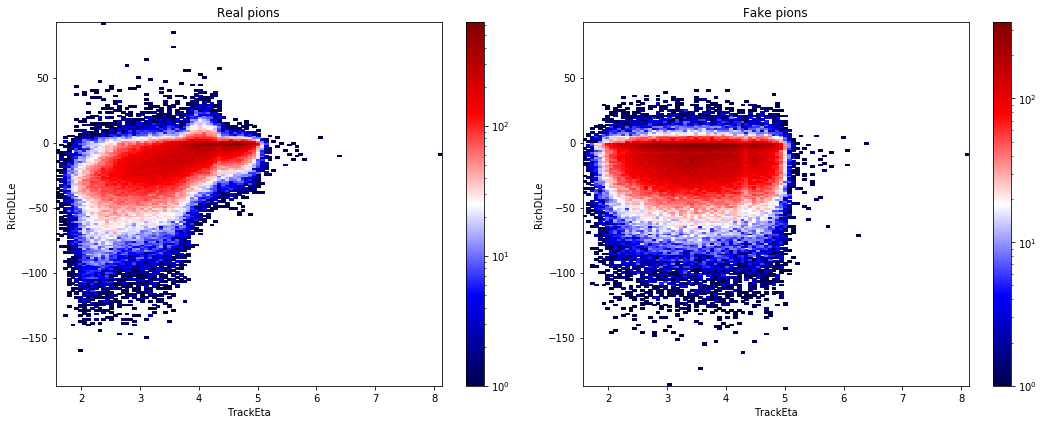

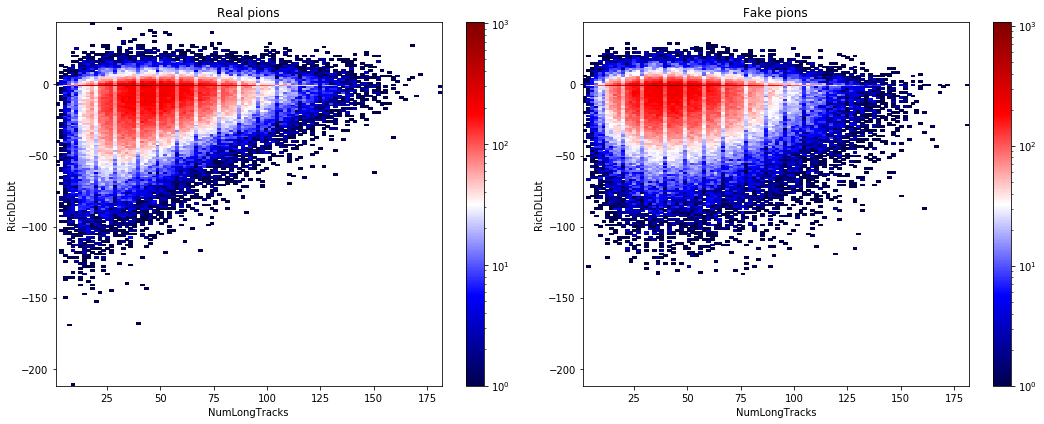

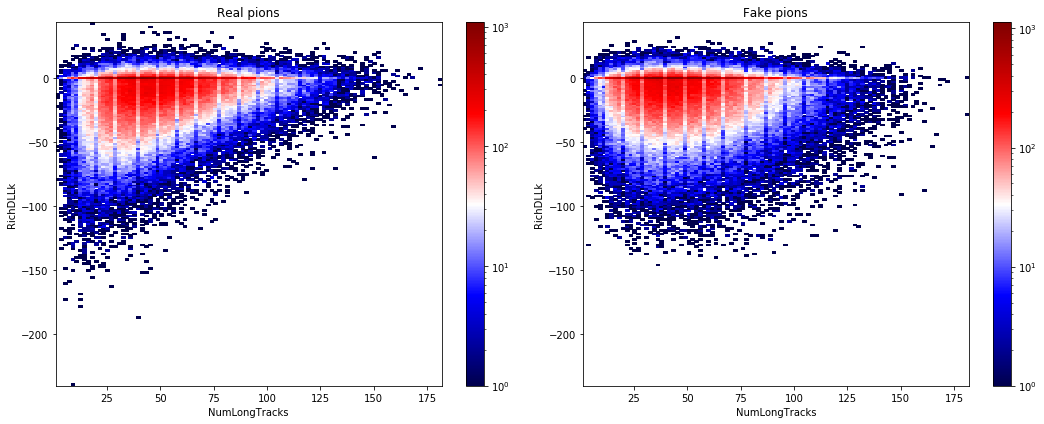

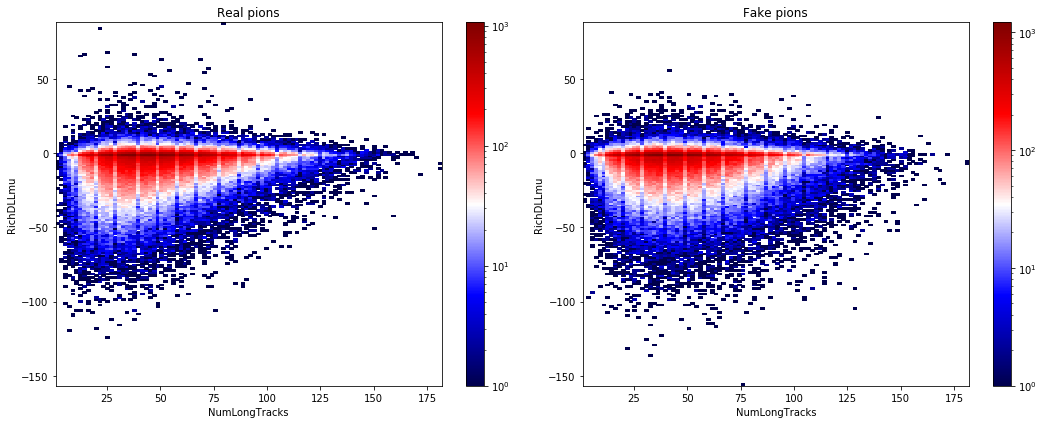

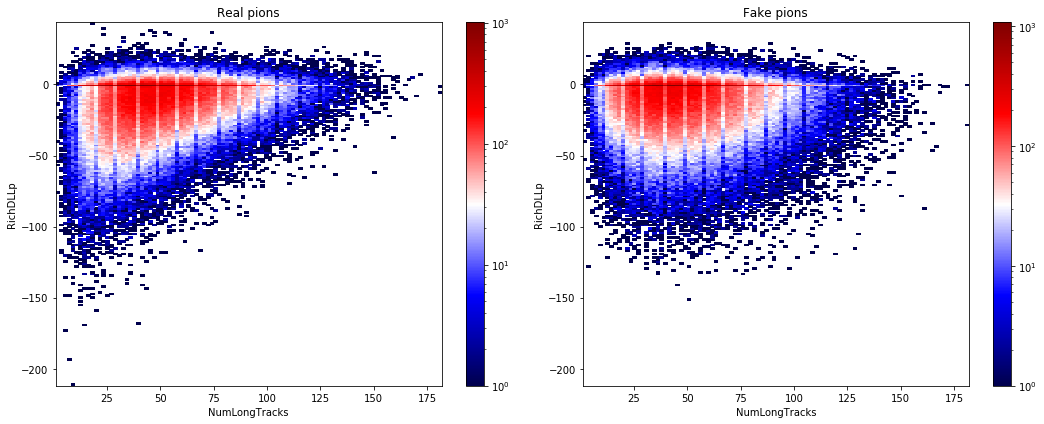

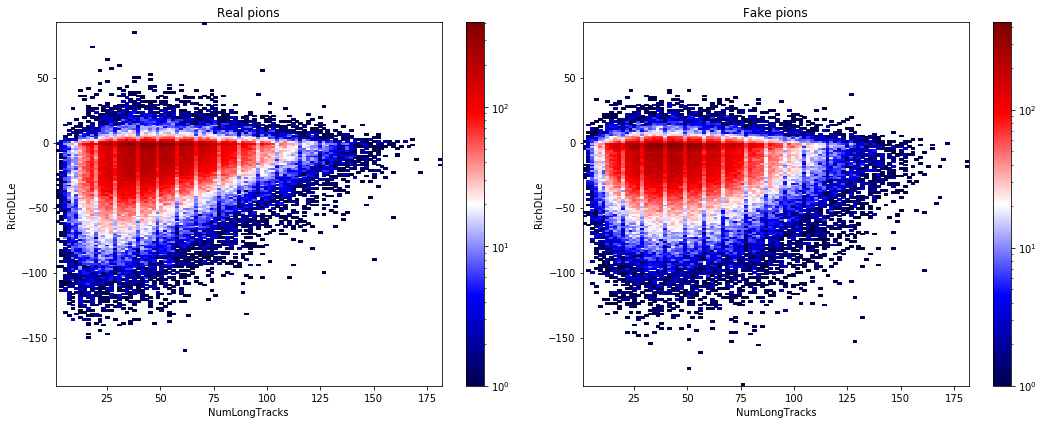

In [0]:
for x_name in x_cols:
    for y_name in y_cols:
        my2d_hist(df_pion.iloc[test_ids], Y_pred_pion, 'pions', x_name, y_name)

#### PROTONS Проверка обучения

In [0]:
train_ids, test_ids = train_test_split(np.arange(len(df_proton)), test_size=0.2, random_state=int(time()))
X, Y = df_proton[x_cols].iloc[train_ids], df_proton[y_cols].iloc[train_ids]
X_test, Y_test = df_proton[x_cols].iloc[test_ids], df_proton[y_cols].iloc[test_ids]


X_DIMS = 3
Y_DIMS = 5
n_hidden_layers = 6
output_dim = 128
n_epochs = 4e4

In [0]:
sess.close()

In [0]:
def model_predict(generator, size, y_cols=y_cols, X_DIMS=X_DIMS):
    Y_pred = generator.predict(sample_noise_batch(bsize=size, X_DIMS=X_DIMS))
    Y_pred = pd.DataFrame(Y_pred)
    Y_pred.columns = y_cols
    return Y_pred

sess = tf.InteractiveSession()

GAN_TYPE = "Jensen-Shannon"
'''
if gan_type == "W":
    GAN_TYPE = "Wasserstein"
elif gan_type == "JS":

else:
    print("Either W or JS\n")
'''

generator_activation = keras.activations.elu
'''
    generator_activation = partial(keras.activations.relu, alpha=0)
'''

with tf.name_scope("Generator"):
    # A few Deconv layers. Feel free to add more, but that will make learning even slower
    generator = Sequential(name="Generator")
    generator.add(L.InputLayer([X_DIMS], name='noise'))
    for i in range(n_hidden_layers):
        generator.add(L.Dense(output_dim, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    #generator.add(L.Dense(128, activation=generator_activation))
    generator.add(L.Dense(Y_DIMS, activation=None))

discriminator_activation = partial(keras.activations.relu, alpha=0.3)
with tf.name_scope("Discriminator"):
    discriminator = Sequential(name="Discriminator")
    discriminator.add(L.InputLayer([Y_DIMS]))
    for i in range(n_hidden_layers):
        discriminator.add(L.Dense(output_dim, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))
    #discriminator.add(L.Dense(128, activation=discriminator_activation))            
    if GAN_TYPE == "Jensen-Shannon":
        # Jensen-Shannon expects probabilities
        discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))
    '''
    elif GAN_TYPE == "Wasserstein":
        # Wasserstein discriminator values are unconstrained
        discriminator.add(L.Dense(1))
    '''

train_batch_size = int(1e3)
real_data = get_tf_dataset(Y, train_batch_size)
real_data = tf.dtypes.cast(real_data, tf.float32)
noise_batch_size = tf.placeholder(tf.int32, shape=[], name="noise_batch_size")
noise = tf.random_normal([noise_batch_size, X_DIMS], dtype=tf.float32, name="noise")
discriminator_real = discriminator(real_data)
generated_data = generator(noise)
discriminator_generated = discriminator(generated_data)

logp_real = discriminator(real_data)
logp_gen = discriminator(generated_data)
discriminator_loss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])

disc_learning_rate = 1e-3
disc_optimizer = tf.train.GradientDescentOptimizer(disc_learning_rate).minimize(
        discriminator_loss, var_list=discriminator.trainable_weights)

generator_loss = -tf.reduce_mean(logp_gen[:,1])

tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
learning_rate = tf.train.exponential_decay(4e-4, tf_iter, 200, 0.98)
gen_optimizer = tf.group(
    tf.train.AdamOptimizer(learning_rate).minimize(generator_loss, var_list=generator.trainable_weights),
    tf.assign_add(tf_iter, 1))

#gen_optimizer = tf.train.AdamOptimizer(1e-4).minimize(generator_loss, var_list=generator.trainable_weights)

'''
if GAN_TYPE == "Wasserstein":
    with tf.name_scope("gradient_loss"):
        alpha = tf.random_uniform(shape=[tf.shape(generated_data)[0], 1], minval=0., maxval=1.)
        interpolates = alpha*real_data + ((1.-alpha)*generated_data)
        disc_interpolates = discriminator(interpolates)
        gradients = tf.gradients(disc_interpolates, [interpolates])[0]
        slopes = tf.norm(tf.reshape(gradients, [tf.shape(gradients)[0], -1]), axis=1)
        gradient_penalty = tf.reduce_mean(tf.square(tf.maximum(tf.abs(slopes) - 1, 0)))
    EMD_loss = tf.reduce_mean(discriminator_generated) - tf.reduce_mean(discriminator_real)
    LAMBDA = 10.
    discriminator_loss = EMD_loss + LAMBDA*gradient_penalty            

    disc_optimizer = tf.train.AdamOptimizer(disc_learning_rate, beta1=0, beta2=0.9).minimize(
           discriminator_loss, var_list=discriminator.trainable_weights)            

    generator_loss = -tf.reduce_mean(discriminator_generated)
    gen_optimizer = tf.train.AdamOptimizer(1e-4, beta1=0, beta2=0.9).minimize(
        generator_loss, var_list=generator.trainable_weights)            
'''

learning_summary = tf.summary.merge([
    tf.summary.scalar("discriminator_loss", discriminator_loss),
    tf.summary.scalar("generator_loss", generator_loss),
])

sess.run(tf.global_variables_initializer())

TOTAL_ITERATIONS = int(n_epochs)
DISCRIMINATOR_ITERATIONS = 5
t = time()
for epoch in range(TOTAL_ITERATIONS):
    for i in range(DISCRIMINATOR_ITERATIONS):
        sess.run(disc_optimizer, {noise_batch_size: train_batch_size})
    summary, _, _ = sess.run([learning_summary, gen_optimizer, tf_iter], {noise_batch_size: train_batch_size})
    
    if epoch % 1000 == 0:
        print("epoch = %d, time %g" % (epoch, time() - t))
        t = time()
        Y_pred = model_predict(generator, len(X) // 10)
        print("predictions generated, time %g" % (time() - t))
        t = time()
        random_indices = np.random.choice(len(Y), size=len(Y) // 10)
        print("score = %g, time %g \n" % (score_func(Y[y_cols].iloc[random_indices], Y_pred), time() - t))
        t = time()
    #summary, _ = sess.run([learning_summary, gen_optimizer], {noise_batch_size: train_batch_size})





epoch = 0, time 0.949349
predictions generated, time 2.9019
score = 0.920112, time 2.52602 

epoch = 1000, time 21.3931
predictions generated, time 1.83592
score = 0.277028, time 2.42672 

epoch = 2000, time 20.5354
predictions generated, time 1.98077
score = 0.186215, time 2.43797 

epoch = 3000, time 20.7245
predictions generated, time 1.9915
score = 0.146577, time 2.46154 

epoch = 4000, time 21.5466
predictions generated, time 1.90994
score = 0.0945012, time 2.44097 

epoch = 5000, time 21.0345
predictions generated, time 1.93824
score = 0.128264, time 2.42565 

epoch = 6000, time 20.2983
predictions generated, time 2.00512
score = 0.0805135, time 2.4122 

epoch = 7000, time 22.1134
predictions generated, time 2.15811
score = 0.101064, time 2.46157 

epoch = 8000, time 20.3417
predictions generated, time 1.80907
score = 0.0564132, time 2.43892 

epoch = 9000, time 20.0804
predictions generated, time 1.95993
score = 0.039488, time 2.39359 

epoch = 10000, time 21.1003
predictions ge

In [0]:
Y_pred_proton = model_predict(generator, len(X_test))

In [0]:
myscore_proton = score_func(Y_test, Y_pred_proton)

In [0]:
print(myscore_proton)

0.01999009995049983


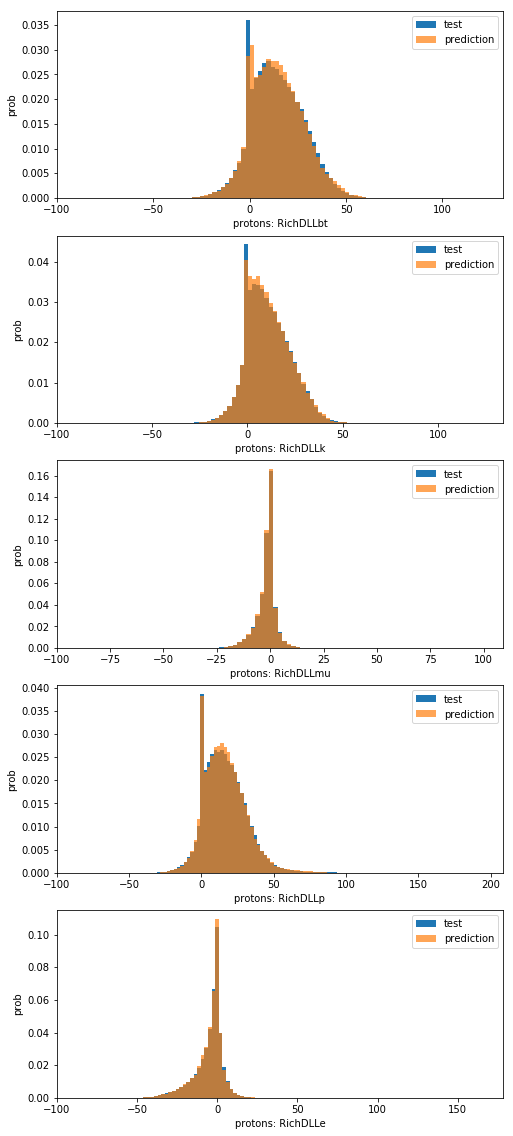

In [0]:
visualise_df([Y_test], [Y_pred_proton], 'protons')

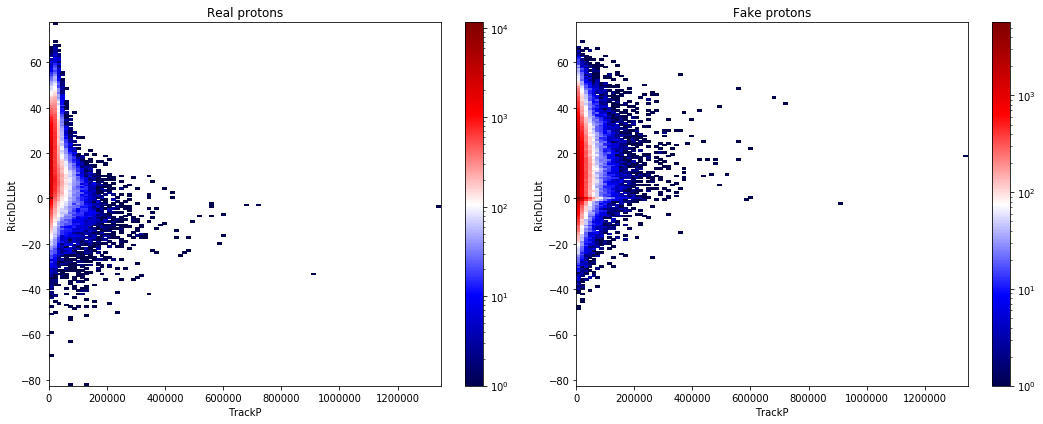

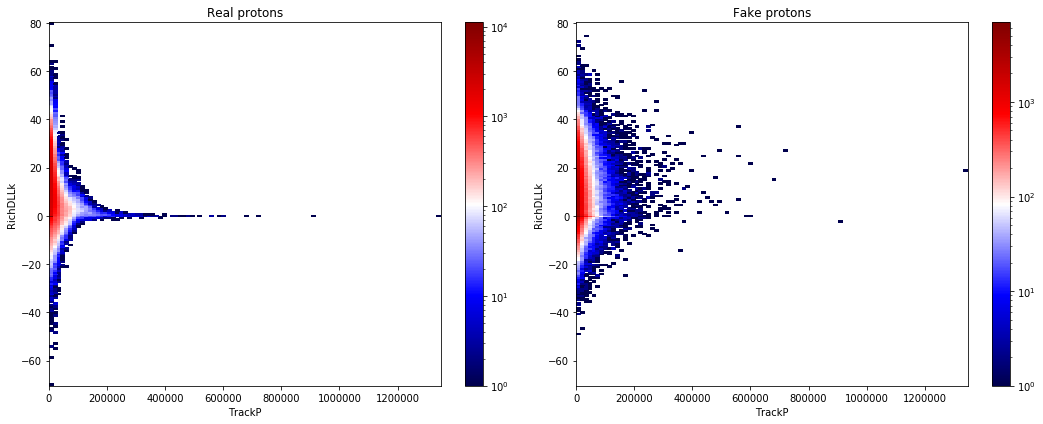

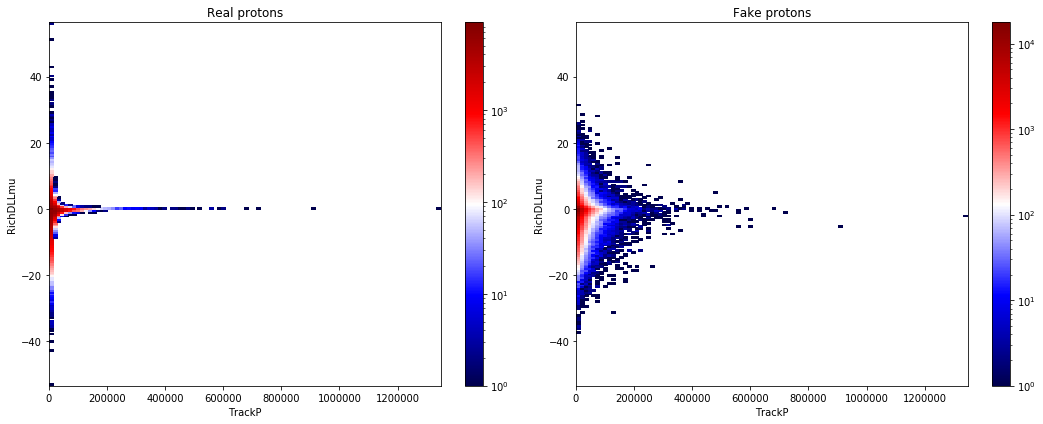

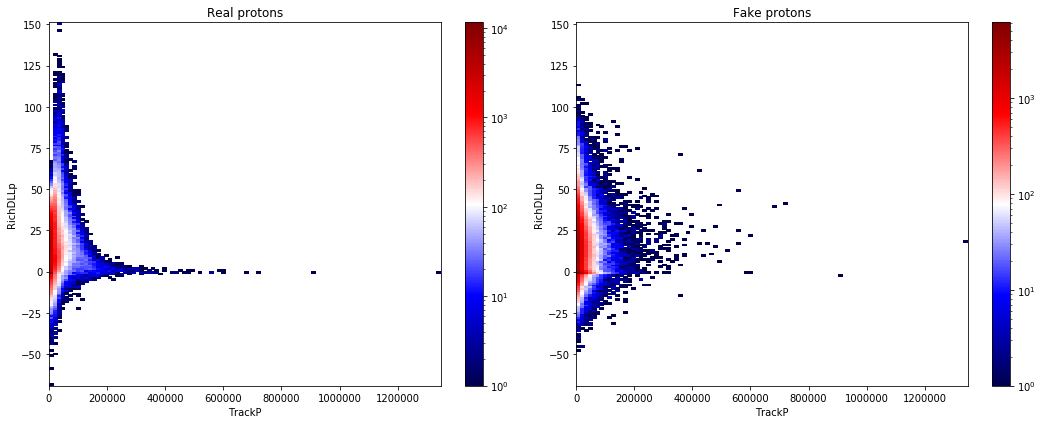

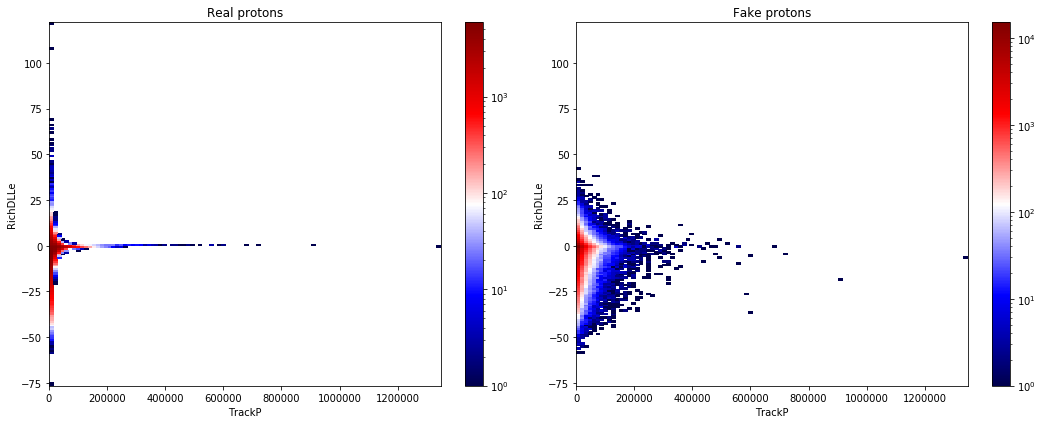

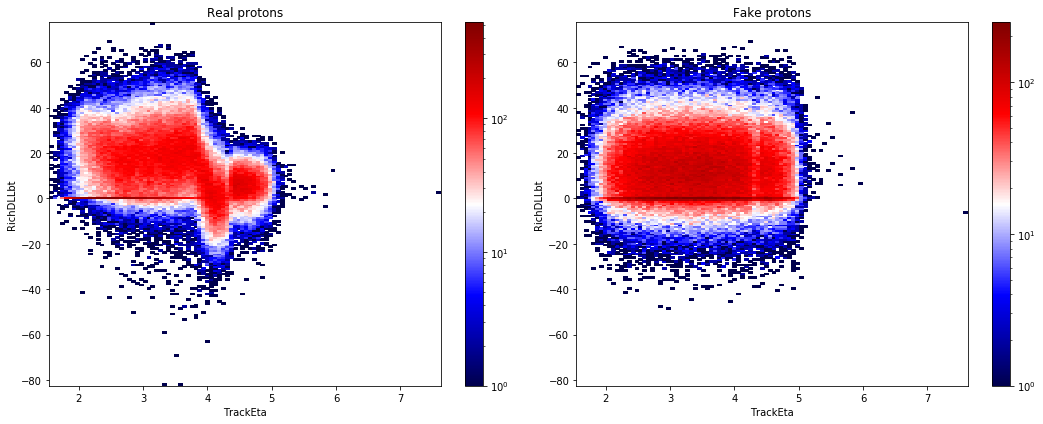

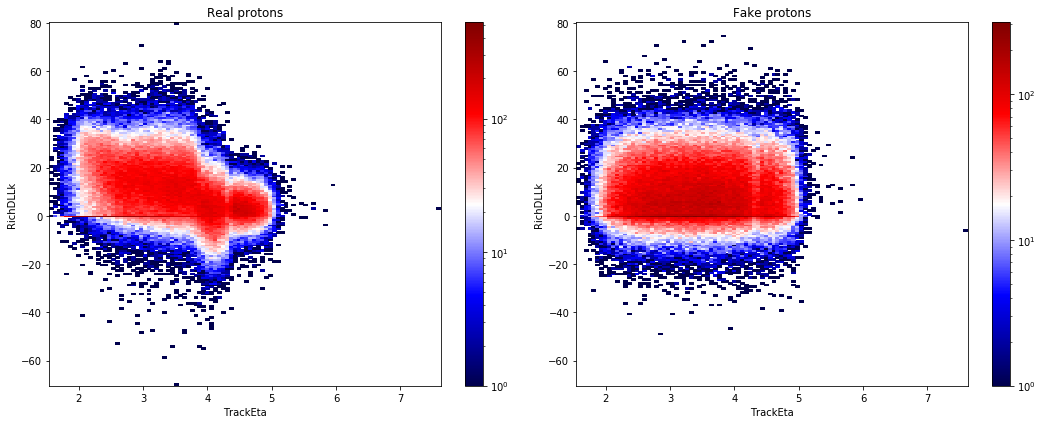

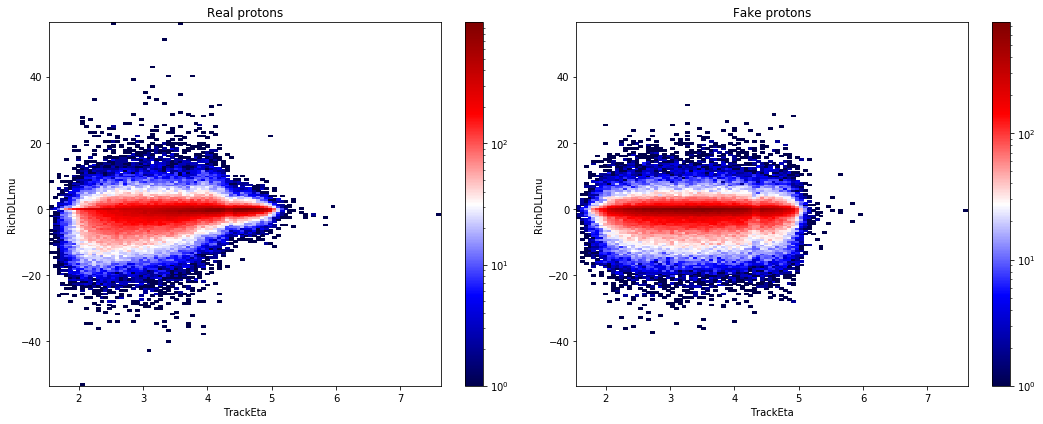

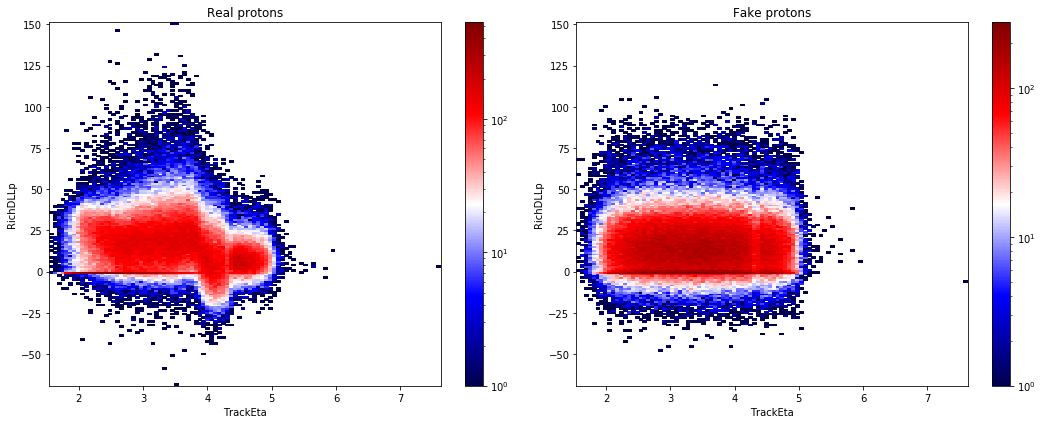

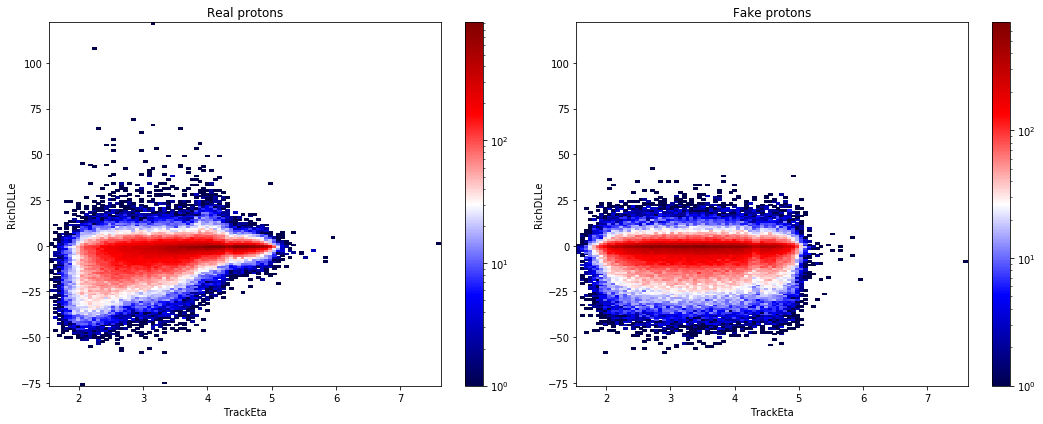

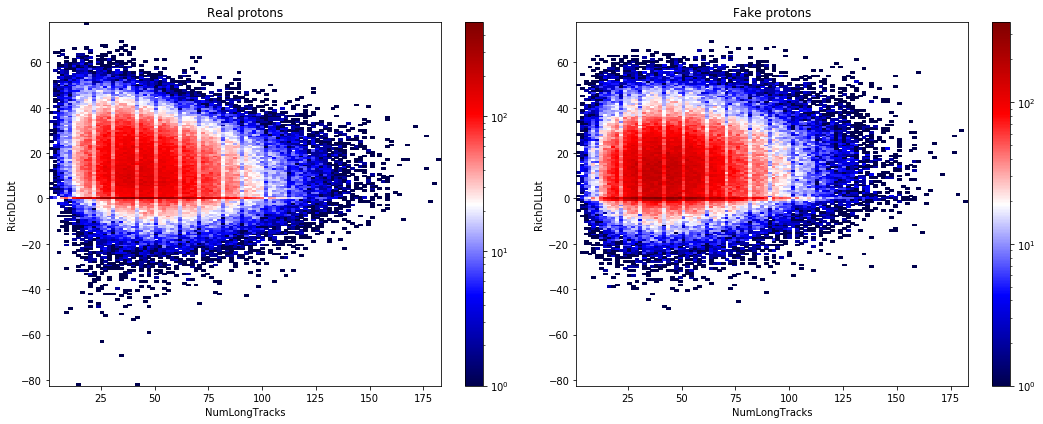

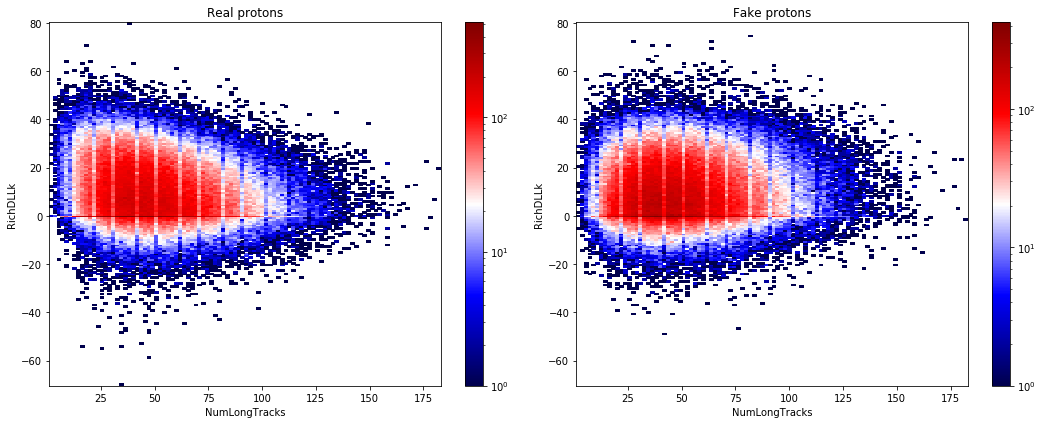

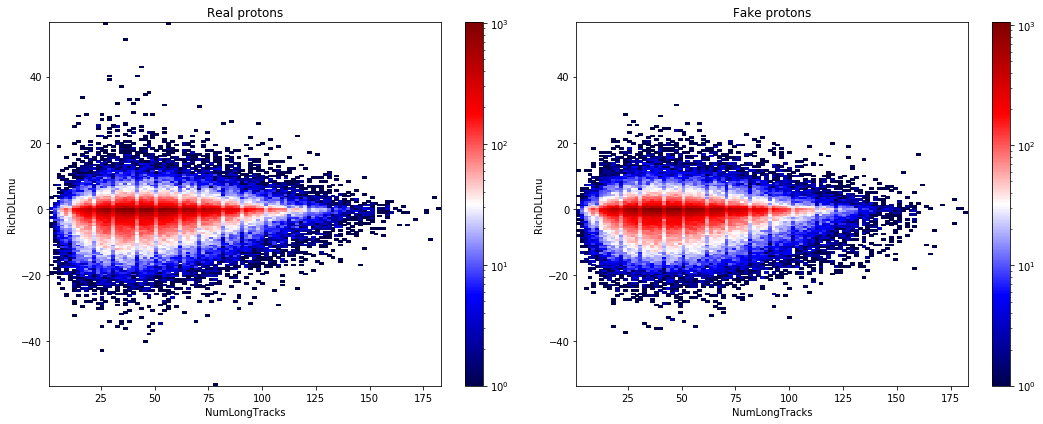

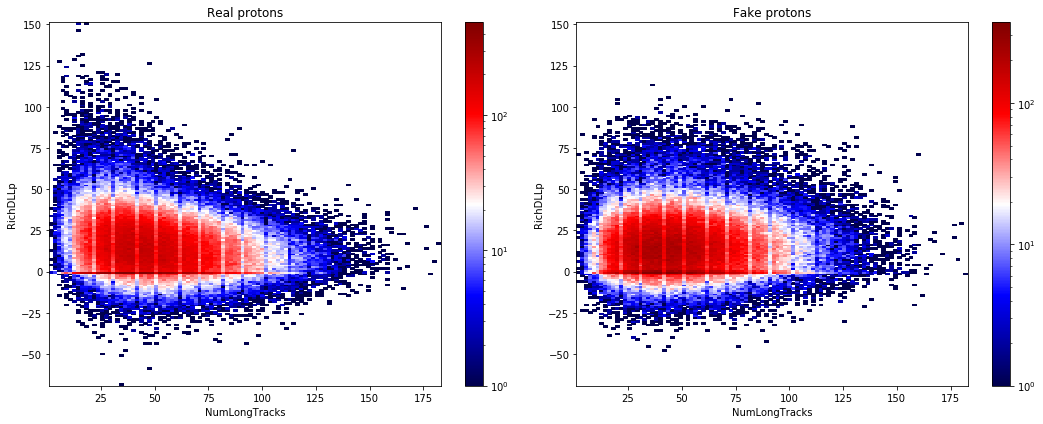

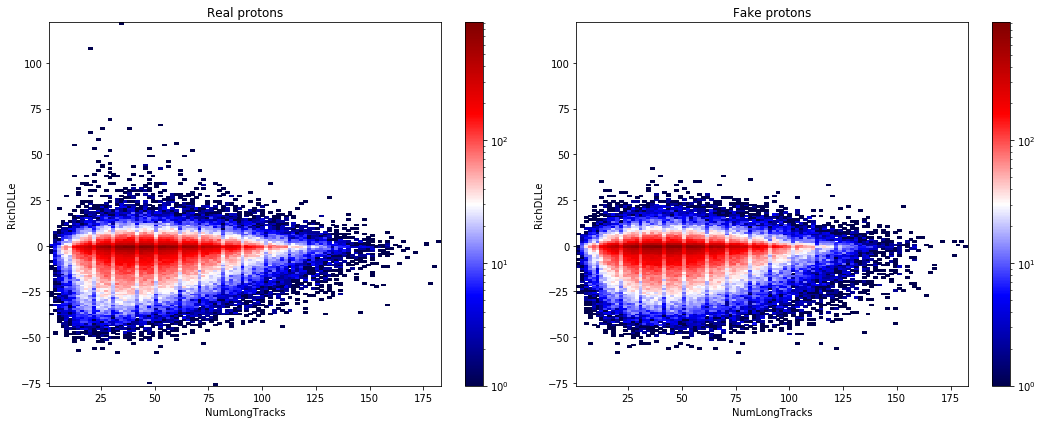

In [0]:
for x_name in x_cols:
    for y_name in y_cols:
        my2d_hist(df_proton.iloc[test_ids], Y_pred_proton, 'protons', x_name, y_name)